In [1]:
import pandas as pd
from google.colab import drive
import os
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder 
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
from scipy.sparse import coo_matrix, hstack
from sklearn.linear_model import SGDClassifier
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.metrics import confusion_matrix 
from scipy.sparse import csr_matrix, csc_matrix
from numpy.random import normal 
from sklearn.decomposition import PCA

In [2]:
drive.mount('/content/drive/') 

Mounted at /content/drive/


<h2>Data Loading<h2>

In [3]:
ddir = '/content/drive/MyDrive/AAIC/Masters/Assignments/consumer_complaints/'
os.chdir(ddir)
file = 'consumer_complaints.csv'
data = pd.read_csv(ddir + file) 
data = data.sample(200000)

data.shape 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(200000, 18)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 256264 to 459356
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 200000 non-null  object
 1   product                       200000 non-null  object
 2   sub_product                   142995 non-null  object
 3   issue                         200000 non-null  object
 4   sub_issue                     76677 non-null   object
 5   consumer_complaint_narrative  24058 non-null   object
 6   company_public_response       30347 non-null   object
 7   company                       200000 non-null  object
 8   state                         198297 non-null  object
 9   zipcode                       198433 non-null  object
 10  tags                          27930 non-null   object
 11  consumer_consent_provided     44337 non-null   object
 12  submitted_via                 200000 non-null  object

#Utility functions

In [5]:
## Reference : AAIC team different project 

def plot_confusion_matrix(test_y, predict_y):
  '''
  plot confusion, precision and recall matrices.
  '''

  C = confusion_matrix(test_y, predict_y)
  A =(((C.T)/(C.sum(axis=1))).T)
  B =(C/C.sum(axis=0))
 
  labels = [0, 1,2,3,4,5,6,7,8,9, 10]
  print("-"*20, "Confusion matrix", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()
 
 
  print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()
 
  # representing B in heatmap format
  print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()


#% null data distribution of column data

In [6]:
# Not Null % for each column
for c in data.columns:
  print(c, (data.shape[0] - data[c].isna().sum() ) * 100.0 / data.shape[0])


date_received 100.0
product 100.0
sub_product 71.4975
issue 100.0
sub_issue 38.3385
consumer_complaint_narrative 12.029
company_public_response 15.1735
company 100.0
state 99.1485
zipcode 99.2165
tags 13.965
consumer_consent_provided 22.1685
submitted_via 100.0
date_sent_to_company 100.0
company_response_to_consumer 100.0
timely_response 100.0
consumer_disputed? 100.0
complaint_id 100.0


#Drop columns post the complaint raise.

There is no point of keep the columns which are related to the post coplaint raise situations. So lets drop them.

In [7]:
# dropping all the post complaint raise variables, 

data = data.drop(['sub_product', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id', 'consumer_consent_provided', 'company_public_response'], axis=1)
data.columns 


Index(['date_received', 'product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'tags',
       'submitted_via'],
      dtype='object')

#remove any duplicate columns

In [8]:
data.drop_duplicates(['product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'tags', 'submitted_via'], inplace=True) 

<h2>Data distribution</h2>

In [9]:
data.value_counts('product')

product
Mortgage                   60984
Debt collection            36121
Credit reporting           29734
Credit card                23435
Bank account or service    21747
Consumer Loan               7588
Student loan                5617
Payday loan                 1367
Money transfers             1344
Prepaid card                 922
Other financial service      207
dtype: int64

#Over the time check the complaints rise or fall trend

We have a date column on complaints so its good that we sort them on the date basis. 

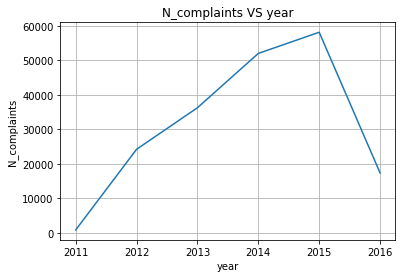

In [10]:
data['date_received'] = pd.to_datetime(data['date_received'], format='%m/%d/%Y')
data.sort_values(by='date_received', inplace=True) 


data.groupby(data['date_received'].dt.year)['date_received'].count().plot()
plt.xlabel('year')
plt.ylabel('N_complaints')
plt.title('N_complaints VS year')
plt.grid()

As we can see that n_complaints have increased over the year.

**Please note** that we will drop this column since we are more into the classification of complaints based on the text or category rather than on the date. 

# Column analysis and distribution

*************************** issue column data analysis and distribution ***************************
% of non null values 100.0
number of unique categories 95



*************************** sub_issue column data analysis and distribution ***************************
% of non null values 100.0
number of unique categories 69



*************************** tags column data analysis and distribution ***************************
% of non null values 14.535664794304635
number of unique categories 4


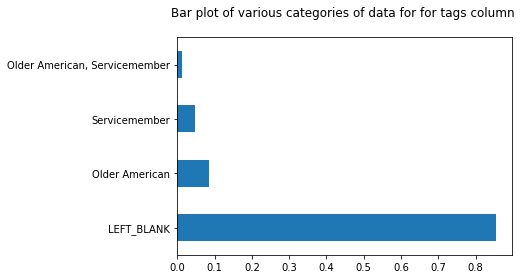




*************************** submitted_via column data analysis and distribution ***************************
% of non null values 100.0
Most frequent category is Web    124003
Name: submitted_via, dtype: int64
number of unique categories for state ['sv_Email', 'sv_Fax', 'sv_Phone', 'sv_Postal mail', 'sv_Referral', 'sv_Web']


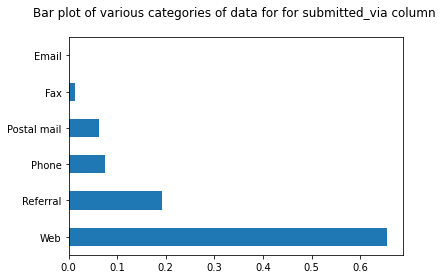




*************************** state column data analysis and distribution ***************************
% of non null data 99.36477209016957
Most frequent category is CA    27430
Name: state, dtype: int64
number of unique categories for state 62



*************************** zipcode column data analysis and distribution ***************************
% of non null data 99.43670464282314
number of unique zip codes in data 20831
Most frequent category is 300XX    434
Name: zipcode, dtype: int64
Assigning the blank value to most frequent category



*************************** region code column data analysis and distribution ***************************
Creating region code variable from region code since there are too many categories for zipcode



*************************** region code column data analysis and distribution ***************************
Creating region code variable from region code since there are too many categories for zipcode
Different categories for region code variable

In [11]:
print('*************************** issue column data analysis and distribution ***************************')

print('% of non null values', (data.shape[0] - pd.isna(data['issue']).sum())*100.0 / data.shape[0])

data.loc[pd.isna(data['issue'])==True, 'issue']='LEFT_BLANK'  # large chunk of this data is null so creating a separate category called "LEFT BLANK"

issue_cols = ['issue_' + str(x) for x in range(len(data['issue'].unique()))] 

print('number of unique categories', len(issue_cols))

print('\n\n')
print('*************************** sub_issue column data analysis and distribution ***************************')


data.loc[pd.isna(data['sub_issue'])==True, 'sub_issue']='LEFT_BLANK'  # large chunk of this data is null so creating a separate category called "LEFT BLANK"

sub_issue_cols = ['sub_issue_' + str(x) for x in range(len(data['sub_issue'].unique()))] 

print('% of non null values', (data.shape[0] - pd.isna(data['sub_issue']).sum())*100.0 / data.shape[0])
print('number of unique categories', len(sub_issue_cols))


print('\n\n')
print('*************************** tags column data analysis and distribution ***************************')

print('% of non null values', (data.shape[0] - pd.isna(data['tags']).sum())*100.0 / data.shape[0])
data.loc[pd.isna(data['tags'])==True, 'tags']='LEFT_BLANK'  # large chunk of this data is null so creating a separate category called "LEFT BLANK"
tags_cols = ['tag_'+ str(x) for x in sorted(data['tags'].unique())] 


print('number of unique categories', len(tags_cols))

a = data['tags'].value_counts()/data['tags'].shape[0]
a.plot(kind='barh')
plt.title('Bar plot of various categories of data for for tags column \n')
plt.show()

plt.close()


print('\n\n')
print('*************************** submitted_via column data analysis and distribution ***************************')

print('% of non null values', (data.shape[0] - pd.isna(data['submitted_via']).sum())*100.0 / data.shape[0])
print('Most frequent category is',data['submitted_via'].value_counts().head(1))
data.loc[pd.isna(data['submitted_via'])==True, 'submitted_via']='Web'  # Assigning the most frequent category.
submitted_via_cols = ['sv_'+ str(x) for x in sorted(data['submitted_via'].unique())] 
print('number of unique categories for state', submitted_via_cols)

a = data['submitted_via'].value_counts()/data['submitted_via'].shape[0]
a.plot(kind='barh')
plt.title('Bar plot of various categories of data for for submitted_via column \n')
plt.show()
plt.close()

print('\n\n')
print('*************************** state column data analysis and distribution ***************************')

# check how many unique catgeories are there and how much of the data is NaN for state variable. If there are not many NaNs then use the most frequent one. 
print('% of non null data', (data.shape[0] - pd.isna(data['state']).sum())*100.0 / data.shape[0])
print('Most frequent category is',data['state'].value_counts().head(1))
data.loc[pd.isna(data['state'])==True, 'state']='CA'  # Assigning the most frequent state column.
state_cols = ['is_'+ str(x) for x in sorted(data['state'].unique())] 
print('number of unique categories for state', len(data['state'].unique()))


print('\n\n')
print('*************************** zipcode column data analysis and distribution ***************************')

print('% of non null data', (data.shape[0] - pd.isna(data['zipcode']).sum())*100.0 / data.shape[0])
unique_zipcodes = set(data.zipcode.unique())
print('number of unique zip codes in data', len(unique_zipcodes))
print('Most frequent category is',data['zipcode'].value_counts().head(1))
print('Assigning the blank value to most frequent category')
data.loc[pd.isna(data.zipcode)==True,'zipcode']=3   # when zip code is blank assign region code as 3 which is most frequent.



print('\n\n')
print('*************************** region code column data analysis and distribution ***************************')

print('Creating region code variable from region code since there are too many categories for zipcode')
data['region_code']=data['zipcode'].str[0]
data.loc[pd.isna(data['region_code'])==True, 'region_code']=data['region_code'].value_counts().head(1).index.values[0]



print('\n\n')
print('*************************** region code column data analysis and distribution ***************************')

print('Creating region code variable from region code since there are too many categories for zipcode')
data['region_code']=data['zipcode'].str[0]
print('Different categories for region code variables are',data['region_code'].value_counts())
print('Asssigning the most frequent region code to blank values')
data.loc[pd.isna(data['region_code'])==True, 'region_code']=data['region_code'].value_counts().head(1).index.values[0]
print('If there are any region codes which are other than 0-9 then removing those')

for k in data['region_code'].value_counts().keys():
  if k.isalpha():
    data.drop(data[data['region_code']==k].index, inplace=True) 

region_code_cols = list(['RC_' + str(x) for x in data['region_code'].unique()])

print('number of unique categories in the region_code', len(region_code_cols))



# Removing less frequent or outlier points because for columns and certain categories under them, 

In [12]:
print('Dropping less frequent categories in data')

orig_n_rows = data.shape[0]

d={}

d['company'] = list(data['company'].value_counts()[data['company'].value_counts()<=2].keys()) 
d['issue'] = list(data['issue'].value_counts()[data['issue'].value_counts()<=5].keys()) 
d['sub_issue'] = list(data['sub_issue'].value_counts()[data['sub_issue'].value_counts()<=5].keys()) 
d['tags'] = list(data['tags'].value_counts()[data['tags'].value_counts()<=5].keys()) 
d['submitted_via'] = list(data['submitted_via'].value_counts()[data['submitted_via'].value_counts()<=5].keys()) 
d['region_code'] = list(data['region_code'].value_counts()[data['region_code'].value_counts()<=10].keys()) 

for k in d.keys():
  for cat in d[k]:
    data.drop(data[data[k]==cat].index, inplace=True)

print('% of data left now', data.shape[0]*100.0/orig_n_rows)


Dropping less frequent categories in data
% of data left now 99.15109009552219


#Multivariate correlation analysis among the state and region code variables.

We will check the relationship of state and region code variables together, since both are categroical variables we will check whether both are related to each other. We will consider the level of significance=0.05 or 5%.

In [13]:
col = ['issue', 'sub_issue', 'company', 'state', 'tags', 'submitted_via', 'region_code']
for c1 in col:
  for c2 in col:
    if c1!=c2:
      contigency_table = pd.crosstab(data[c1], data[c2], margins = False)
      stat, p, dof, expected = chi2_contingency(contigency_table)
      print('Probability that H0 that ', c1, c2, ' are independent of each other is ', p)

Probability that H0 that  issue sub_issue  are independent of each other is  0.0
Probability that H0 that  issue company  are independent of each other is  0.0
Probability that H0 that  issue state  are independent of each other is  0.0
Probability that H0 that  issue tags  are independent of each other is  0.0
Probability that H0 that  issue submitted_via  are independent of each other is  0.0
Probability that H0 that  issue region_code  are independent of each other is  0.0
Probability that H0 that  sub_issue issue  are independent of each other is  0.0
Probability that H0 that  sub_issue company  are independent of each other is  0.0
Probability that H0 that  sub_issue state  are independent of each other is  0.0
Probability that H0 that  sub_issue tags  are independent of each other is  0.0
Probability that H0 that  sub_issue submitted_via  are independent of each other is  0.0
Probability that H0 that  sub_issue region_code  are independent of each other is  0.0
Probability that H

So we can see that mostly columns or variables are dependent on each other. Least correlated are region_code and tags whereas issue and sub_issue are most correlated with each other. Also region_code and state are very much similar.

**Represent department name with number**

In [14]:
Y = data['product'].map({'Credit card':0, 'Mortgage':1, 'Bank account or service':2, 'Consumer Loan':3, 'Student loan':4, 'Credit reporting':5, 'Money transfers':6, 'Debt collection':7, 'Payday loan':8, 'Prepaid card':9, 'Other financial service':10})
X = data.drop(['product', 'date_received'], axis=1) 

# Train test split.

In [165]:
trainx, testx, trainy, testy = train_test_split(X,Y, test_size=0.3, stratify=Y)

#Analyzing the train data. Asking some EDA questions.

1. Against which product the complaints are most frequent in nature?

In [16]:
data['product'].value_counts().head(1)

Mortgage    60584
Name: product, dtype: int64

2. What type of complaints is very general in nature? [issue]?

In [ ]:
data['issue'].value_counts().head(1)

Loan modification,collection,foreclosure    15996
Incorrect information on credit report      10882
Name: issue, dtype: int64

2. Which companies have low reputation in general? 

In [17]:
data['company'].value_counts().head(1)

Bank of America    17528
Name: company, dtype: int64

3. Which state has most complaints? 

In [19]:
data['state'].value_counts().head(1)

CA    28413
Name: state, dtype: int64

4. Which means is more frequent way of complaints to be filed? 

In [20]:
data['submitted_via'].value_counts().head(1) 

Web    122710
Name: submitted_via, dtype: int64

<h3>Categorical variables one hot encoding</h3>

In [21]:
import joblib

In [22]:
ohe_tags = OneHotEncoder(handle_unknown='ignore')
trainx_tags = ohe_tags.fit_transform(trainx['tags'].values.reshape(-1,1))
testx_tags = ohe_tags.transform(testx['tags'].values.reshape(-1,1))
tags_features = ohe_tags.get_feature_names_out(['tags'])


ohe_submitted_via = OneHotEncoder(handle_unknown='ignore')
trainx_submitted_via = ohe_submitted_via.fit_transform(trainx['submitted_via'].values.reshape(-1,1))
testx_submitted_via = ohe_submitted_via.transform(testx['submitted_via'].values.reshape(-1,1))
submitted_via_features = ohe_submitted_via.get_feature_names_out(['sv'])

ohe_issue = OneHotEncoder(handle_unknown='ignore')
trainx_issue = ohe_issue.fit_transform(trainx['issue'].values.reshape(-1,1))
testx_issue = ohe_issue.transform(testx['issue'].values.reshape(-1,1))
issue_features = ohe_issue.get_feature_names_out(['issue'])

ohe_sub_issue = OneHotEncoder(handle_unknown='ignore')
trainx_sub_issue = ohe_sub_issue.fit_transform(trainx['sub_issue'].values.reshape(-1,1))
testx_sub_issue = ohe_sub_issue.transform(testx['sub_issue'].values.reshape(-1,1))
si_features = ohe_sub_issue.get_feature_names_out(['si'])

ohe_state = OneHotEncoder(handle_unknown='ignore')
trainx_state = ohe_state.fit_transform(trainx['state'].values.reshape(-1,1))
testx_state = ohe_state.transform(testx['state'].values.reshape(-1,1))
state_features = ohe_state.get_feature_names_out(['state'])

ohe_rc = OneHotEncoder(handle_unknown='ignore')
trainx_region_code = ohe_rc.fit_transform(trainx['region_code'].values.reshape(-1,1))
testx_region_code = ohe_rc.transform(testx['region_code'].values.reshape(-1,1))
rc_features = ohe_rc.get_feature_names_out(['rc'])

<h2>consumer narrative variable</h2>

Consumer narrative is the actual text we need to preprocess and clean and filter out the important words. Based on those words, We will decide which department or product a partcular complaint belongs to. In preprocessing we will remove html tags, punctuations, any non alphabetical characters etc. 


In [23]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
    
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned 

import re

def preprocessing(sen):
  sen = re.sub(r'https?://(www\.)?', ' ', sen)    # remove https and wwww from the sentence.
  sen = cleanhtml(sen)                            # remove html tags
  sen = re.sub(r'(\{\$\d*\.\d{1,2}\})', ' ', sen) # remove money
  sen = re.sub(r'XX*', ' ', sen)                  # remove XX 
  sen = cleanpunc(sen)                            # clean punctuation
  sen = re.sub('\d+',' ', sen)                    # remove numbers 
  sen = re.sub(r'\s+', ' ',sen )                  # remove multiple spaces
  sen = ' '.join(list(filter(lambda x: len(x)>=3, sen.split())))   # remove words less than 3 letters long
  sen = sen.lower()
  return sen

  

**cleaning up the consumer complaint narrative for train and test data and creating binary vectorization for them.**

1.   Handle blank values.
2.   Creating binary vectors using tfidf vectorizer.




In [24]:
trainx.loc[pd.isna(trainx['consumer_complaint_narrative'])==True, 'consumer_complaint_narrative']='LEFT_BLANK'
testx.loc[pd.isna(testx['consumer_complaint_narrative'])==True, 'consumer_complaint_narrative']='LEFT_BLANK'

train_sens = trainx['consumer_complaint_narrative'].values 
test_sens = testx['consumer_complaint_narrative'].values

stopwords = set(["will", "would", "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", "mustn'", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't", "above", "below", "to", "from", "up", "down", "in", "out" ,"on", "off", "over", "under",  "again", "further", "am", "is", "are", "was", "were",  "be", "been", "being", "have", "has", "had", "having", "do", "does", 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 'won', "won't", 'wouldn', "wouldn't", 'theirs', 'can', 'again', 'do', 'while', 'doesn', 'into', 'her', 'other', "aren't", 'before', 'ourselves', 'about', 'to', 'nor', 'too', "it's", 'same', 'haven', 'most', 'been', 'any', 'has', "shan't", 'themselves', 's', 'at', 'did', 'this', "mustn't", "wasn't", 'than', 'above', 'won', 'over', 'ain', 'will', "you're", 'so', 'off', 'are', 'down', 'how', 'some', 'own', 'i', 'their', 'for', 'y', 'who', "wouldn't", 'which', 'very', 'didn', 'isn', 'between', 'under', 'from', 'of', 'by', "don't", 'just', 'she', "you'll", 'is', 'they', 'shouldn', 'its', 'during', "you've", 'ours', "isn't", 'our', "hasn't", 'why', 'through', 'on', 'further', 've', 'what', 'after', 'mightn', 'in', 'because', "you'd", 'he', 'yourself', 'those', 'needn', 'yourselves', 'does', 'or', 'until', "haven't", 'aren', "weren't", 'were', 'don', 'them', 'your', 'm', 'hers', 'shan', 'that', 'against', 'few', "didn't", 'once', 'itself', 'me', 're', 'him', 'whom', 'but', 'hasn', 'myself', 'when', 'wouldn', 'each', 'a', 'such', 'not', "won't", "couldn't", 'out', 'o', "hadn't", 'mustn', 't', 'ma', 'all', 'as', 'if', 'an', 'd', 'the', 'couldn', 'am', 'no', 'my', 'where', "needn't", "that'll", 'himself', 'yours', "she's", 'with', 'and', 'herself', 'doing', "doesn't", "shouldn't", 'up', 'we', 'be', "mightn't", 'weren', 'only', 'here', 'both', 'it', 'these', 'have', 'hadn', "should've", 'more', 'was', 'had', 'his', 'then', 'should', 'now', 'being', 'having', 'll', 'you', 'below', 'wasn', 'there', 'br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "she's'", "her", "hers", "herself", "it", "it's", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that",  "these", "those"])


# preprocess the train data points 

cleaned_train_cn_text=[]
for sen in train_sens:
  train_sen = preprocessing(sen)
  words = train_sen.split()
  cleaned_train_cn_sent=[]
  for word in words:
    if word not in stopwords:
      cleaned_train_cn_sent.append(word) 
  cleaned_train_cn_sent = ' '.join(cleaned_train_cn_sent)
  cleaned_train_cn_text.append(cleaned_train_cn_sent)

# preprocess the test data points 

cleaned_test_cn_text=[]
for sen in test_sens:
  test_sen = preprocessing(sen)
  words = test_sen.split()
  cleaned_test_cn_sent=[]
  for word in words:
    if word not in stopwords:
      cleaned_test_cn_sent.append(word) 
  cleaned_test_cn_sent = ' '.join(cleaned_test_cn_sent)
  cleaned_test_cn_text.append(cleaned_test_cn_sent)


# create binary featurization 


# # TFIDF
tfidfvec_cn = TfidfVectorizer(min_df=10, max_features=5000, stop_words=stopwords)
tfidf_cn_train_matrix = tfidfvec_cn.fit_transform(cleaned_train_cn_text)
tfidf_cn_test_matrix = tfidfvec_cn.transform(cleaned_test_cn_text)
tfidf_cn_features = np.array(tfidfvec_cn.get_feature_names())



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#dealing with company names

<h4>1. Cleaning up the company names and creating vectors for each company row.</h4>

In [25]:
X.loc[pd.isna(X['company'])==True, 'company']='LEFT_BLANK'

company_names = X['company'].values

stopwords = set(["will", "would", "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", "mustn'", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't", "above", "below", "to", "from", "up", "down", "in", "out" ,"on", "off", "over", "under",  "again", "further", "am", "is", "are", "was", "were",  "be", "been", "being", "have", "has", "had", "having", "do", "does", 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 'won', "won't", 'wouldn', "wouldn't", 'theirs', 'can', 'again', 'do', 'while', 'doesn', 'into', 'her', 'other', "aren't", 'before', 'ourselves', 'about', 'to', 'nor', 'too', "it's", 'same', 'haven', 'most', 'been', 'any', 'has', "shan't", 'themselves', 's', 'at', 'did', 'this', "mustn't", "wasn't", 'than', 'above', 'won', 'over', 'ain', 'will', "you're", 'so', 'off', 'are', 'down', 'how', 'some', 'own', 'i', 'their', 'for', 'y', 'who', "wouldn't", 'which', 'very', 'didn', 'isn', 'between', 'under', 'from', 'of', 'by', "don't", 'just', 'she', "you'll", 'is', 'they', 'shouldn', 'its', 'during', "you've", 'ours', "isn't", 'our', "hasn't", 'why', 'through', 'on', 'further', 've', 'what', 'after', 'mightn', 'in', 'because', "you'd", 'he', 'yourself', 'those', 'needn', 'yourselves', 'does', 'or', 'until', "haven't", 'aren', "weren't", 'were', 'don', 'them', 'your', 'm', 'hers', 'shan', 'that', 'against', 'few', "didn't", 'once', 'itself', 'me', 're', 'him', 'whom', 'but', 'hasn', 'myself', 'when', 'wouldn', 'each', 'a', 'such', 'not', "won't", "couldn't", 'out', 'o', "hadn't", 'mustn', 't', 'ma', 'all', 'as', 'if', 'an', 'd', 'the', 'couldn', 'am', 'no', 'my', 'where', "needn't", "that'll", 'himself', 'yours', "she's", 'with', 'and', 'herself', 'doing', "doesn't", "shouldn't", 'up', 'we', 'be', "mightn't", 'weren', 'only', 'here', 'both', 'it', 'these', 'have', 'hadn', "should've", 'more', 'was', 'had', 'his', 'then', 'should', 'now', 'being', 'having', 'll', 'you', 'below', 'wasn', 'there', 'br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "she's'", "her", "hers", "herself", "it", "it's", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that",  "these", "those"])


# preprocess the train data points 

cleaned_company=[]
for com in company_names:
  com = preprocessing(com)
  words = com.split()
  cleaned_comp=[]
  for word in words:
    if word not in stopwords:
      cleaned_comp.append(word) 
  cleaned_comp = ' '.join(cleaned_comp)
  cleaned_company.append(cleaned_comp)

# create binary featurization 


# # TFIDF
tfidfvec_company = TfidfVectorizer(min_df=5, max_features=5000, stop_words=stopwords)
tfidf_comp_matrix = tfidfvec_company.fit_transform(cleaned_company)
tfidf_comp_features = tfidfvec_company.get_feature_names()



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<h4> 2. Grouping the company names into different cluster names using kmeans based on the similarity of text vectors  </h4>

In [26]:
scores=[]
inertias=[]

for k in range(3,18,2):
  km = KMeans(n_clusters=k)
  km.fit(tfidf_comp_matrix)
  scores.append(silhouette_score(tfidf_comp_matrix, km.labels_))
  inertias.append(km.inertia_)

To asses how well kmeans model was able to seggregate the data into clusters, we plot below graphs for train and test data.

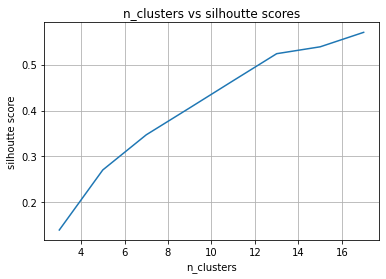

In [27]:
plt.plot(list(range(3,18,2)), scores) 
plt.xlabel('n_clusters')
plt.ylabel('silhoutte score')
plt.title('n_clusters vs silhoutte scores')
plt.grid()

No handles with labels found to put in legend.


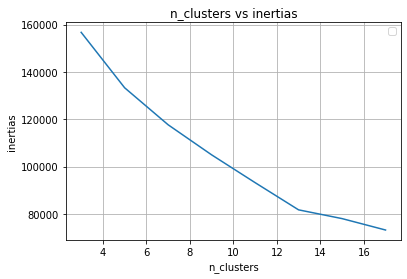

In [29]:
plt.plot(list(range(3,18,2)), inertias)
plt.xlabel('n_clusters')
plt.ylabel('inertias')
plt.title('n_clusters vs inertias')
plt.legend()
plt.grid()


<h4>Now with best possible number of clusters, we will predict the class labels,  group the data points into the cluster groups, Merge these one hot encoded variable with the main data.</h4>


In [30]:
n_cls=13
km_comp = KMeans(n_clusters=n_cls)
km_comp.fit(tfidf_comp_matrix)
company_name_clusters=km_comp.labels_

trainx_comp = company_name_clusters[:trainx.shape[0]]
testx_comp = company_name_clusters[trainx.shape[0]:]

ohe_comp = OneHotEncoder()
trainx_comp_ohe = ohe_comp.fit_transform(trainx_comp.reshape(-1,1))
testx_comp_ohe = ohe_comp.transform(testx_comp.reshape(-1,1))
comp_group = np.array(['comp' + str(c) for c in range(n_cls)])

In [31]:
trainx_tags.shape, trainx_submitted_via.shape, trainx_issue.shape, trainx_sub_issue.shape, trainx_state.shape, trainx_region_code.shape, tfidf_cn_train_matrix.shape, trainx_comp_ohe.shape, \
testx_tags.shape, testx_submitted_via.shape, testx_issue.shape, testx_sub_issue.shape, testx_state.shape, testx_region_code.shape, tfidf_cn_test_matrix.shape, testx_comp_ohe.shape

((131222, 4),
 (131222, 6),
 (131222, 91),
 (131222, 68),
 (131222, 62),
 (131222, 11),
 (131222, 5000),
 (131222, 13),
 (56239, 4),
 (56239, 6),
 (56239, 91),
 (56239, 68),
 (56239, 62),
 (56239, 11),
 (56239, 5000),
 (56239, 13))

# combine multiple features and columns into one.

In [130]:
train_data = hstack([trainx_tags, trainx_submitted_via, trainx_issue, trainx_sub_issue, trainx_state, trainx_region_code, tfidf_cn_train_matrix, trainx_comp_ohe])
test_data = hstack([testx_tags, testx_submitted_via, testx_issue, testx_sub_issue, testx_state, testx_region_code, tfidf_cn_test_matrix, testx_comp_ohe])
all_features = np.hstack([tags_features, submitted_via_features, issue_features, si_features, state_features, rc_features, tfidf_cn_features, comp_group])

In [ ]:

print(trainx_tags.shape, tags_features.shape)
print(trainx_submitted_via.shape, submitted_via_features.shape)
print(trainx_issue.shape, issue_features.shape)
print(trainx_sub_issue.shape, si_features.shape)
print(trainx_region_code.shape, rc_features.shape)
print(trainx_state.shape, state_features.shape)
print(tfidf_cn_train_matrix.shape, tfidf_cn_features.shape)
print(trainx_comp_ohe.shape, comp_group.shape)

print(train_data.shape, test_data.shape , all_features.shape)

(13158, 4) (4,)
(13158, 6) (6,)
(13158, 79) (79,)
(13158, 62) (62,)
(13158, 10) (10,)
(13158, 57) (57,)
(13158, 1489) (1489,)
(13158, 9) (9,)
(13158, 1716) (5640, 1716) (1716,)


<h2>Data visualization</h2>

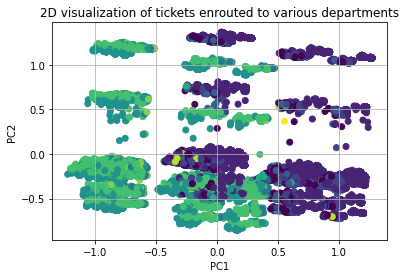

In [34]:
pca = PCA(n_components=2) 
x_new = pca.fit_transform(test_data.toarray()) 

plt.scatter(x_new[:,0], x_new[:,1], c = testy) 
# labels = np.unique(trainy)
# handles = [plt.Line2D([],[],marker="o", ls="", 
#                       color=plt.scatter.cmap(plt.scatter.norm(yi))) for yi in labels]
# plt.legend()

plt.xlabel('PC1') 
plt.ylabel('PC2') 
plt.grid() 
plt.title('2D visualization of tickets enrouted to various departments') 
plt.show() 



It shows how the tickets could be divided across departments of multiple colors.

#Modelling on the data

#1. Baseline model

Baseline model would randomly predict the departement or product given the train or test data.

In [35]:
testy_pred = np.zeros((len(testy),11))  
for i in range(len(testy_pred)):
 rand_probs = np.random.rand(1,11) 
 testy_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
# print("Log loss on Test Data using Random Model",log_loss(testy, testy_pred,eps=1e-15))
testy_pred_label =np.argmax(testy_pred, axis=1)
# plot_confusion_matrix(y_test, predicted_y) 

In [36]:
print('recall_score', recall_score(testy, testy_pred_label, average='micro'))
print('precision_score', precision_score(testy, testy_pred_label, average='micro'))
print('f1_score', f1_score(testy, testy_pred_label, average='micro') )

recall_score 0.08927968135991038
precision_score 0.08927968135991038
f1_score 0.08927968135991038


#Naive Bayes

In [40]:
import datetime

In [46]:
t = datetime.datetime.now()

In [47]:
mnb = MultinomialNB()
mnb.fit(train_data, trainy)
clb = CalibratedClassifierCV(mnb, cv='prefit')
clb.fit(train_data, trainy)

test_data_pred=clb.predict_proba(test_data) 
train_data_pred=clb.predict_proba(train_data) 

train_data_pred_label=clb.predict(train_data)
test_data_pred_label=clb.predict(test_data)

ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

# ohe=OneHotEncoder() 
trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))


print('train recall score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),3), 'test recall score', round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),3))
print('train precision score', round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),3), 'test precision score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),3))
print('train f1 score', round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),3), 'test f1 score', round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),3))



train recall score 0.988 test recall score 0.987
train precision score 0.987 test precision score 0.988
train f1 score 0.987 test f1 score 0.988


latency for naive bayes 0:00:13.964894


In [51]:

param_grid={'alpha':[10**x for x in range(-5,5)]} 

mnb = MultinomialNB()
grid = GridSearchCV(mnb, param_grid, scoring='f1_micro')
grid.fit(train_data, trainy)
grid.best_score_, grid.best_params_ 



(0.9935529145723289, {'alpha': 0.01})

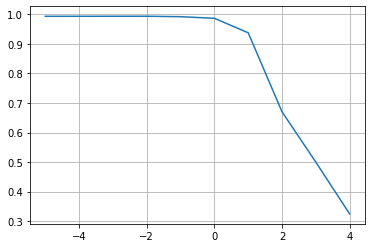

In [52]:
mnb_scores = grid.cv_results_['mean_test_score']
alphas=np.log10(param_grid['alpha'])
plt.plot(alphas, mnb_scores)
plt.grid()


In [53]:
mnb = MultinomialNB(alpha=0.01)
mnb.fit(train_data, trainy)
clb = CalibratedClassifierCV(mnb, cv='prefit')
clb.fit(train_data, trainy)

test_data_pred=clb.predict_proba(test_data) 
train_data_pred=clb.predict_proba(train_data) 

train_data_pred_label=clb.predict(train_data)
test_data_pred_label=clb.predict(test_data)

ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

# ohe=OneHotEncoder() 
trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))


mnb_train_recall = round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)
mnb_test_recall = round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),8)

mnb_train_precision = round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8) 
mnb_test_precision = round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),8)

mnb_train_f1_score = round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)
mnb_test_f1_score = round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),8)                          


print('train recall score', mnb_train_recall, 'test recall score', mnb_test_recall)
print('train precision score', mnb_train_precision , 'test precision score', mnb_test_precision)
print('train f1 score', mnb_train_f1_score, 'test f1 score', mnb_test_f1_score)



train recall score 0.99436832 test recall score 0.99431
train precision score 0.99436832 test precision score 0.99431
train f1 score 0.99436832 test f1 score 0.99431


# confusion matrix

Below is how the product name and label relation as shown in the confusion, recall and precision matrix
-------------------- Confusion matrix --------------------


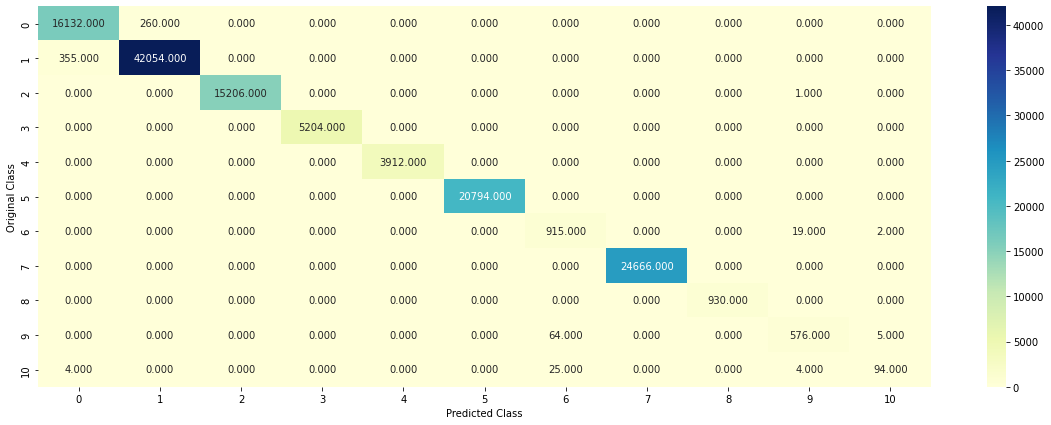

-------------------- Precision matrix (Columm Sum=1) --------------------


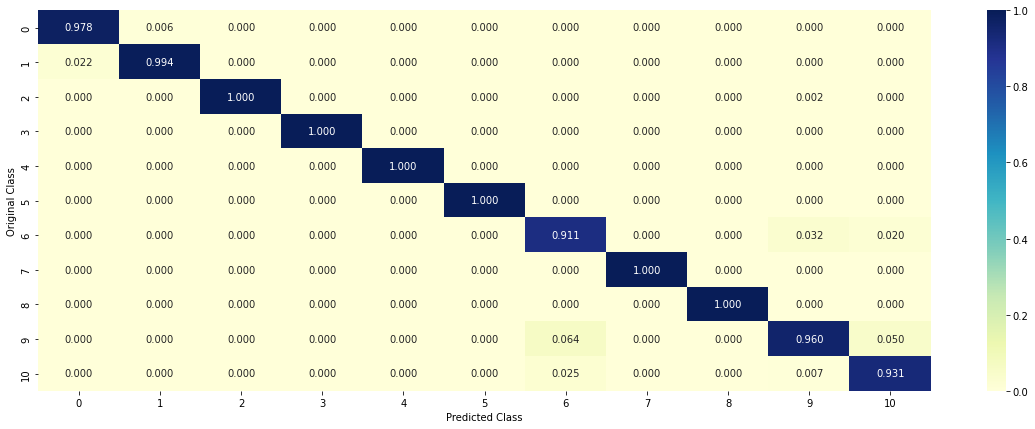

-------------------- Recall matrix (Row sum=1) --------------------


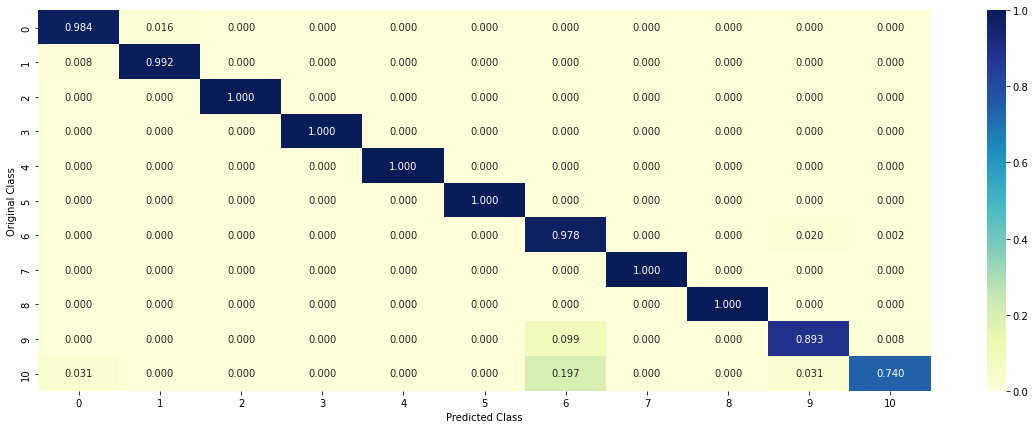

In [54]:
print('Below is how the product name and label relation as shown in the confusion, recall and precision matrix')

plot_confusion_matrix(trainy, train_data_pred_label) 

Below is how the product name and label relation as shown in the confusion, recall and precision matrix
-------------------- Confusion matrix --------------------


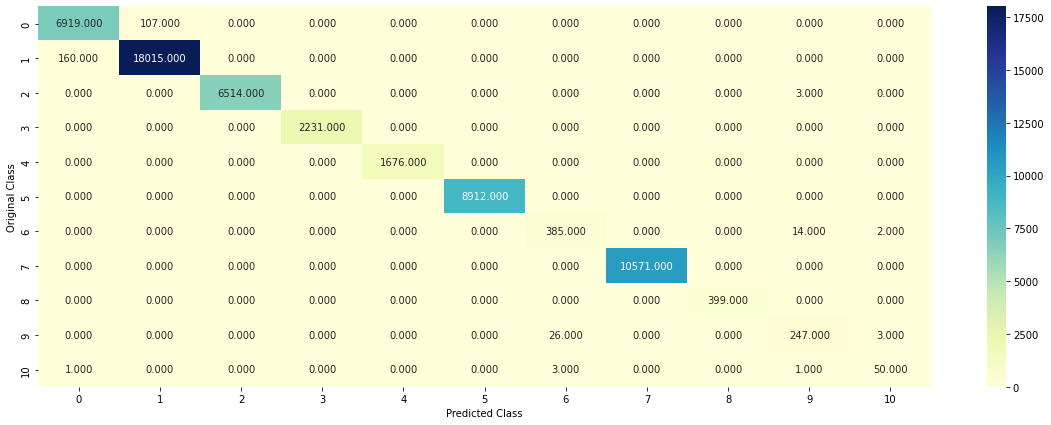

-------------------- Precision matrix (Columm Sum=1) --------------------


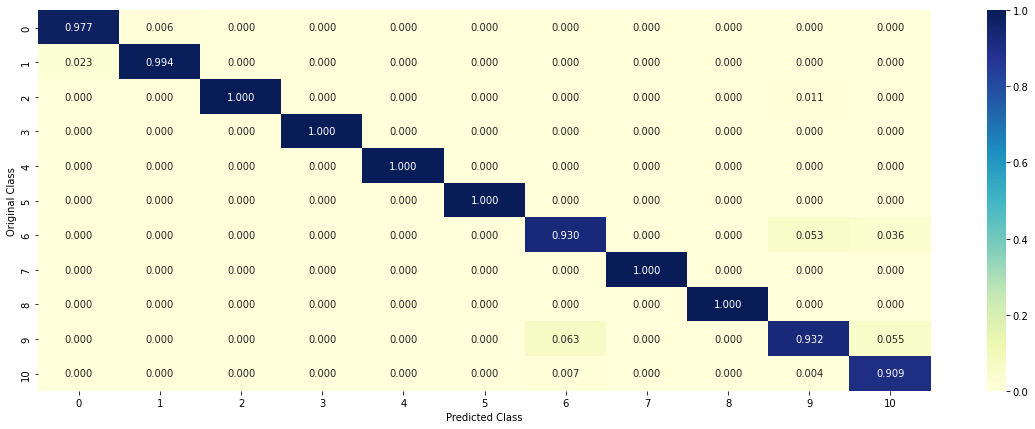

-------------------- Recall matrix (Row sum=1) --------------------


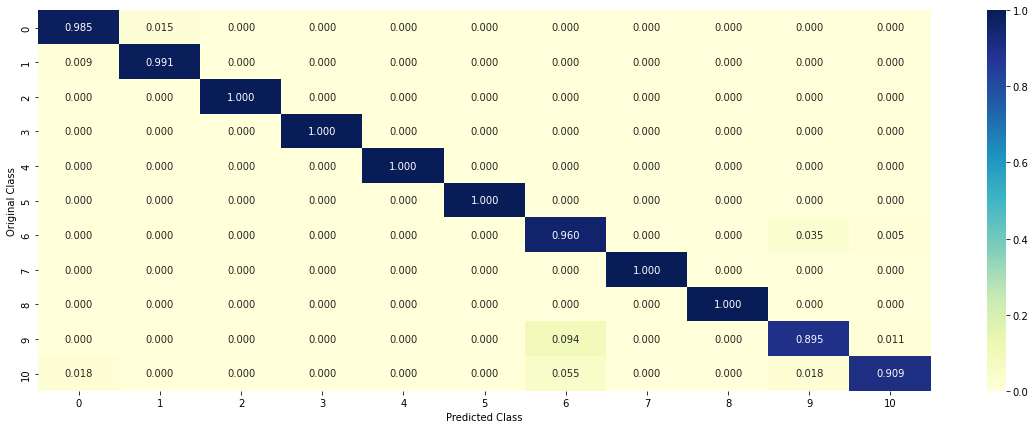

In [55]:
print('Below is how the product name and label relation as shown in the confusion, recall and precision matrix')

plot_confusion_matrix(testy, test_data_pred_label) 

From the precision matrix and recall matrix, we can see that model is getting slightly confused between few classes as shown above.

#Error analysis

In [56]:
for i, j in zip(testx.loc[testy[testy==10].index, 'issue'], testx[test_data_pred_label==10]['issue']):
  if i!=j:
    print(i,'====>', j)
    print('\n')

Fraud or scam ====> Customer service/Customer relations


Advertising and marketing ====> Customer service/Customer relations


Customer service/Customer relations ====> Excessive fees


Fraud or scam ====> Customer service/Customer relations


Excessive fees ====> Customer service/Customer relations


Customer service/Customer relations ====> Lost or stolen check


Customer service/Customer relations ====> Unexpected/Other fees


Lost or stolen check ====> Disclosures


Customer service/Customer relations ====> Excessive fees


Disclosures ====> Customer service/Customer relations


Unexpected/Other fees ====> Excessive fees


Excessive fees ====> Disclosures


Customer service/Customer relations ====> Lost or stolen money order


Excessive fees ====> Customer service/Customer relations


Disclosures ====> Customer service/Customer relations


Lost or stolen money order ====> Fraud or scam


Customer service/Customer relations ====> Disclosures


Disclosures ====> Lost or stolen money

As we can see that model is getting confused among ustomer service/Customer relations Customer service/Customer relations ====>excessive fees
====> Fraud or scam ====> lost oe stolen check ect. sometimes due to which are getting wrong results, however it is minimal and not much.




<h1> 2. SVM classifier </h1>

In [57]:
from sklearn.linear_model import SGDClassifier

In [58]:
svm = SGDClassifier(loss='hinge')
svm.fit(train_data, trainy)
clb = CalibratedClassifierCV(svm, cv='prefit')
clb.fit(train_data, trainy)

test_data_pred=clb.predict_proba(test_data) 
train_data_pred=clb.predict_proba(train_data) 

train_data_pred_label=clb.predict(train_data)
test_data_pred_label=clb.predict(test_data)

ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

# ohe=OneHotEncoder() 
trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))


print('train recall score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),3), 'test recall score', round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),3))
print('train precision score', round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),3), 'test precision score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),3))
print('train f1 score', round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),3), 'test f1 score', round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),3))


train recall score 0.996 test recall score 0.996
train precision score 0.996 test precision score 0.996
train f1 score 0.996 test f1 score 0.996


<h2> Hyper parameter tunning</h2>

In [60]:
param_grid={'alpha':[10**x for x in range(-5,5)]} 

svm = SGDClassifier(loss='hinge')
grid = GridSearchCV(svm, param_grid, scoring='f1_micro')
grid.fit(train_data, trainy)
grid.best_score_, grid.best_params_ 

(0.9960067672727032, {'alpha': 1e-05})

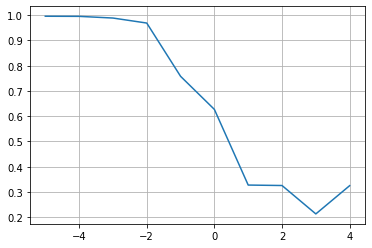

In [61]:
scores = grid.cv_results_['mean_test_score']
alphas=np.log10(param_grid['alpha'])
plt.plot(alphas, scores)
plt.grid()

In [143]:
svm = SGDClassifier(loss='hinge', alpha=0.00001)
svm.fit(train_data, trainy)
clb = CalibratedClassifierCV(svm, cv='prefit')
clb.fit(train_data, trainy)

test_data_pred=clb.predict_proba(test_data) 
train_data_pred=clb.predict_proba(train_data) 

train_data_pred_label=clb.predict(train_data)
test_data_pred_label=clb.predict(test_data)

ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

# ohe=OneHotEncoder() 
trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))



svm_train_recall = round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)
svm_test_recall = round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),8)

svm_train_precision = round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8) 
svm_test_precision = round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),8)

svm_train_f1_score = round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)
svm_test_f1_score = round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),8)                          


print('train recall score', svm_train_recall, 'test recall score', svm_test_recall)
print('train precision score', svm_train_precision , 'test precision score', svm_test_precision)
print('train f1 score', svm_train_f1_score, 'test f1 score', svm_test_f1_score)





train recall score 0.99658594 test recall score 0.99633706
train precision score 0.99658594 test precision score 0.99633706
train f1 score 0.99658594 test f1 score 0.99633706


**Confusion matrix**

Below is how the product name and label relation as shown in the confusion, recall and precision matrix
-------------------- Confusion matrix --------------------


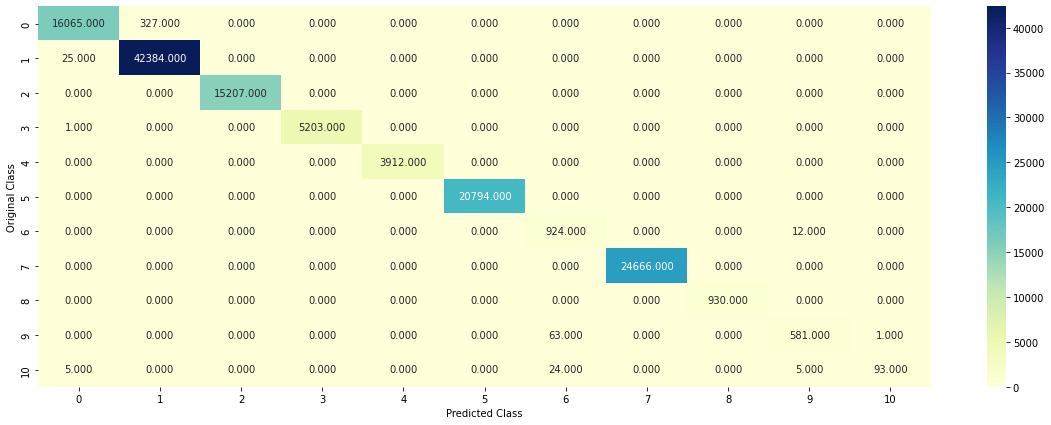

-------------------- Precision matrix (Columm Sum=1) --------------------


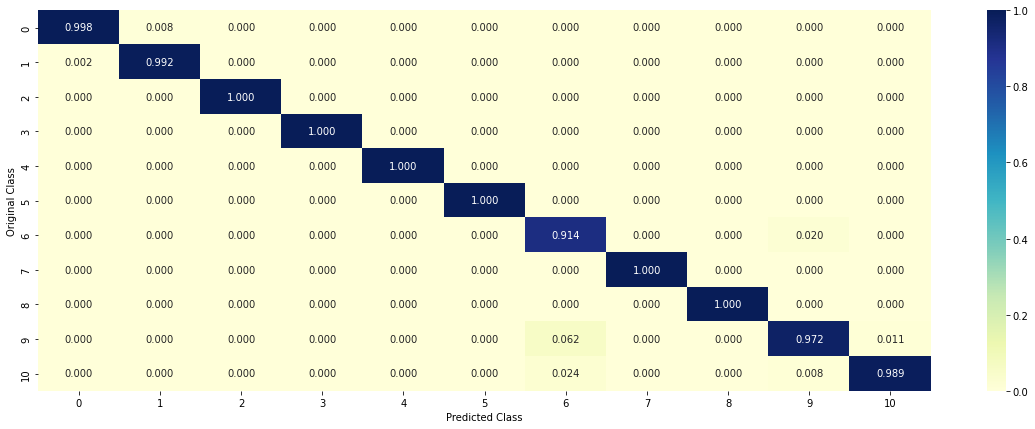

-------------------- Recall matrix (Row sum=1) --------------------


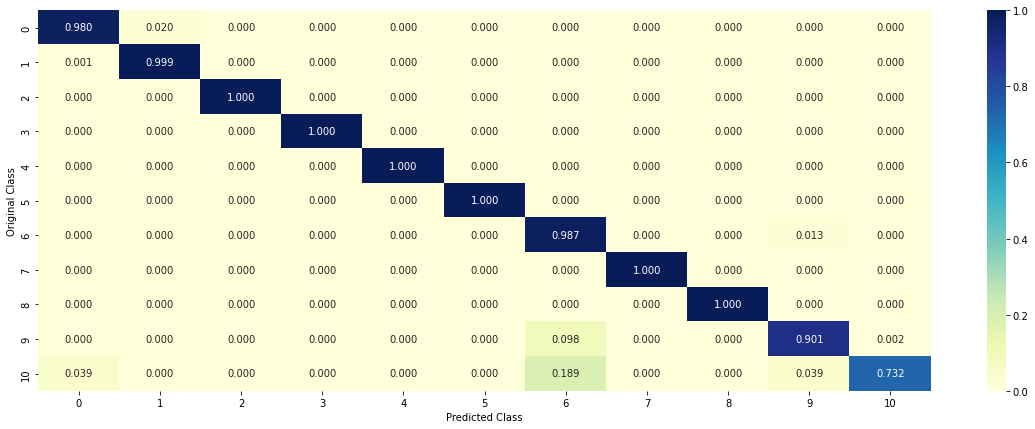

In [63]:
print('Below is how the product name and label relation as shown in the confusion, recall and precision matrix')

plot_confusion_matrix(trainy, train_data_pred_label) 

-------------------- Confusion matrix --------------------


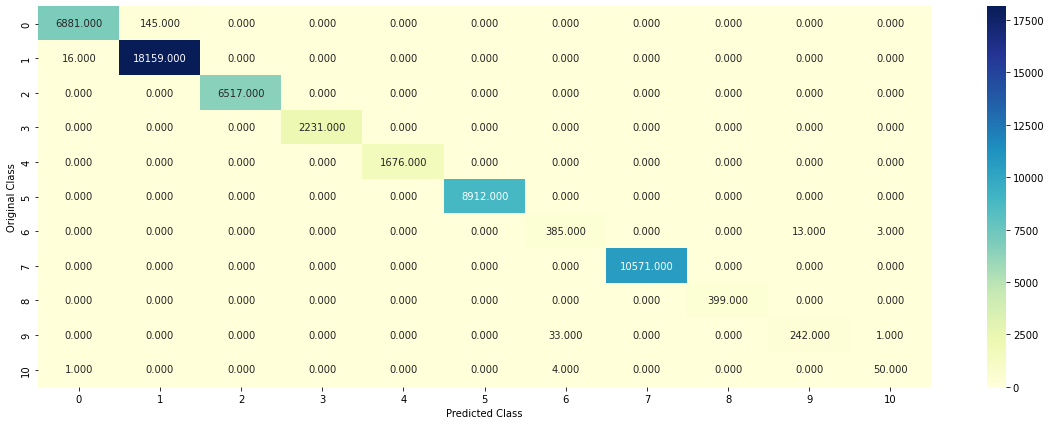

-------------------- Precision matrix (Columm Sum=1) --------------------


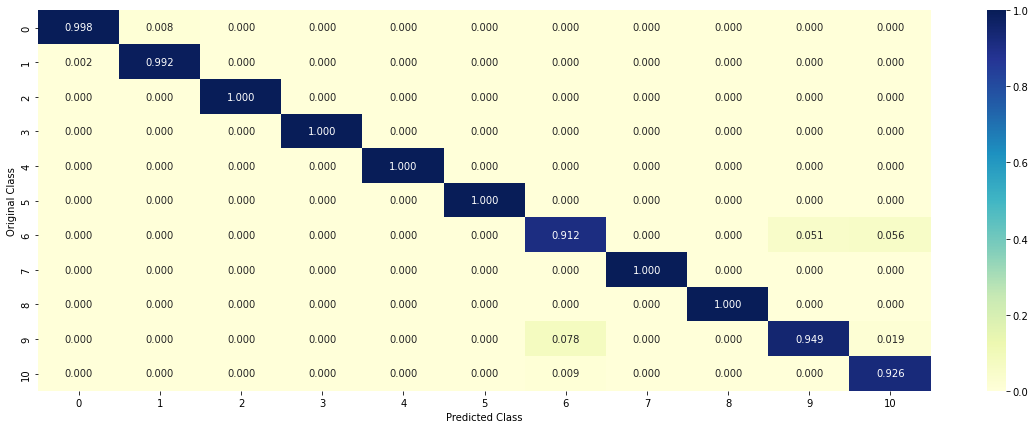

-------------------- Recall matrix (Row sum=1) --------------------


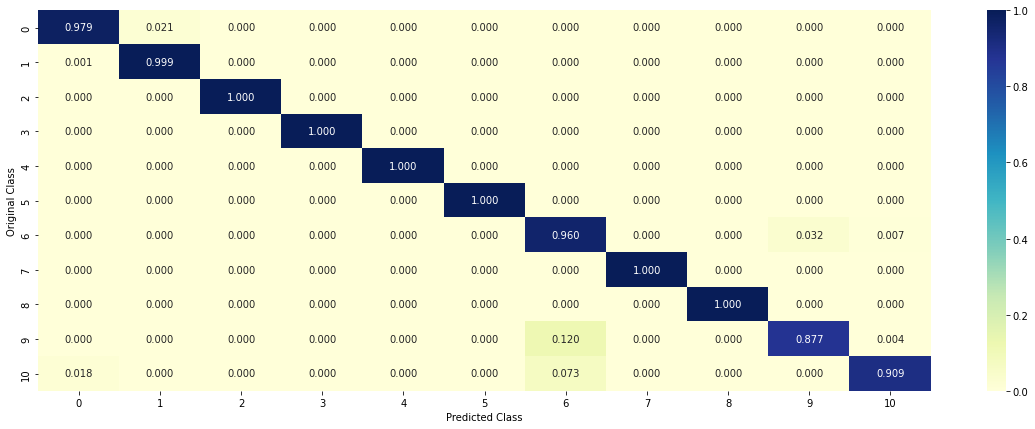

In [64]:
plot_confusion_matrix(testy, test_data_pred_label) 

**Error Analysis**

In [65]:
for i, j in zip(testx.loc[testy[testy==10].index, 'issue'], testx[test_data_pred_label==10]['issue']):
  if i!=j:
    print(i,'====>', j)
    print('\n')

Fraud or scam ====> Customer service/Customer relations


Advertising and marketing ====> Customer service/Customer relations


Customer service/Customer relations ====> Excessive fees


Fraud or scam ====> Customer service/Customer relations


Excessive fees ====> Customer service/Customer relations


Customer service/Customer relations ====> Lost or stolen check


Lost or stolen check ====> Fraud or scam


Customer service/Customer relations ====> Lost or stolen check


Customer service/Customer relations ====> Unexpected/Other fees


Lost or stolen check ====> Customer service/Customer relations


Unexpected/Other fees ====> Disclosures


Customer service/Customer relations ====> Unexpected/Other fees


Disclosures ====> Excessive fees


Unexpected/Other fees ====> Customer service/Customer relations


Customer service/Customer relations ====> Disclosures


Excessive fees ====> Lost or stolen money order


Disclosures ====> Customer service/Customer relations


Lost or stolen money 

As we can see that model is getting confused among ustomer service/Customer relations Customer service/Customer relations ====>excessive fees ====> Fraud or scam ====> lost oe stolen check ect. sometimes due to which are getting wrong results, however it is minimal and not much.

# 3. Logistic regression

In [135]:

print(train_data.shape, test_data.shape, trainy.shape, testy.shape)


lr = LogisticRegression(max_iter=500, class_weight='balanced', dual=False)  
lr.fit(train_data, trainy)
clb = CalibratedClassifierCV(lr, cv='prefit')
clb.fit(train_data, trainy)

test_data_pred=lr.predict_proba(test_data) 
train_data_pred=lr.predict_proba(train_data) 

train_data_pred_label=lr.predict(train_data)
test_data_pred_label=lr.predict(test_data)

ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))


print('train recall score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),3), 'test recall score', round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),3))
print('train precision score', round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),3), 'test precision score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),3))
print('train f1 score', round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),3), 'test f1 score', round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),3)) 


(131222, 5255) (56239, 5255) (131222,) (56239,)
train recall score 0.994 test recall score 0.993
train precision score 0.993 test precision score 0.994
train f1 score 0.993 test f1 score 0.994


In [ ]:
import warnings
warnings.filterwarnings('ignore')

<h3> Hyper paramater tunning of logistic regression</h3>

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


grid_best_score grid_best_param 0.9949627327567552 {'C': 10000}


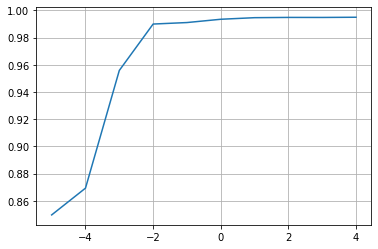

In [136]:
param_grid={'C':[10**x for x in range(-5,5)]} 

lr = SGDClassifier(loss='log', class_weight='balanced')
grid = GridSearchCV(lr, param_grid, scoring='f1_micro')
grid.fit(train_data, trainy)
print('grid_best_score', 'grid_best_param', grid.best_score_, grid.best_params_)

scores = grid.cv_results_['mean_test_score']
alphas=np.log10(param_grid['C'])
plt.plot(alphas, scores)
plt.grid() 



In [138]:
print(train_data.shape, test_data.shape, trainy.shape, testy.shape)

lr = LogisticRegression(max_iter=500, class_weight='balanced', C=10000)
lr.fit(train_data, trainy)

test_data_pred=lr.predict_proba(test_data) 
train_data_pred=lr.predict_proba(train_data) 

train_data_pred_label=lr.predict(train_data)
test_data_pred_label=lr.predict(test_data)

ohe_lr=OneHotEncoder()
trainy_ohe = ohe_lr.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe_lr.transform(np.asarray(testy).reshape(-1,1))

trainy_pred_ohe = ohe_lr.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe_lr.transform(np.asarray(test_data_pred_label).reshape(-1,1))


print('train recall score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8), 'test recall score', round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),8))
print('train precision score', round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),8), 'test precision score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8))
print('train f1 score', round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),8), 'test f1 score', round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)) 



(131222, 5255) (56239, 5255) (131222,) (56239,)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


train recall score 0.99588484 test recall score 0.99480787
train precision score 0.99480787 test precision score 0.99588484
train f1 score 0.99480787 test f1 score 0.99588484


# COnfusion Matrix

Below is how the product name and label relation as shown in the confusion, recall and precision matrix
-------------------- Confusion matrix --------------------


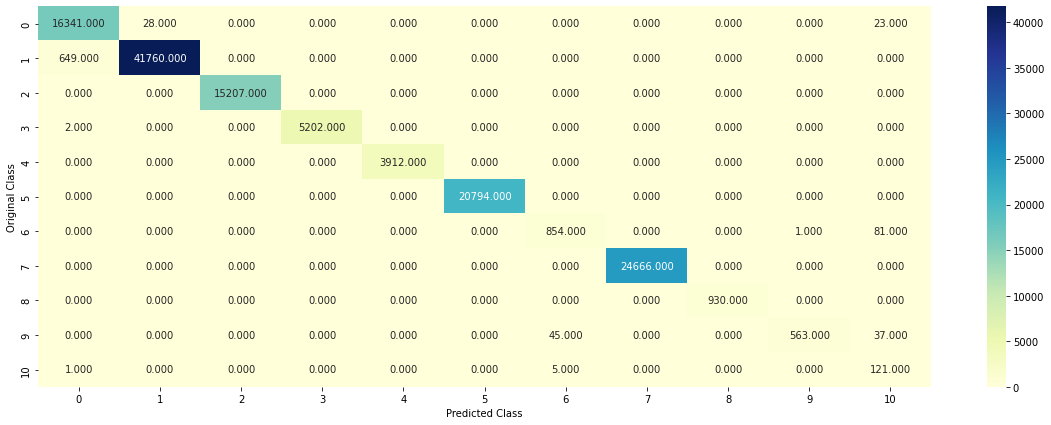

-------------------- Precision matrix (Columm Sum=1) --------------------


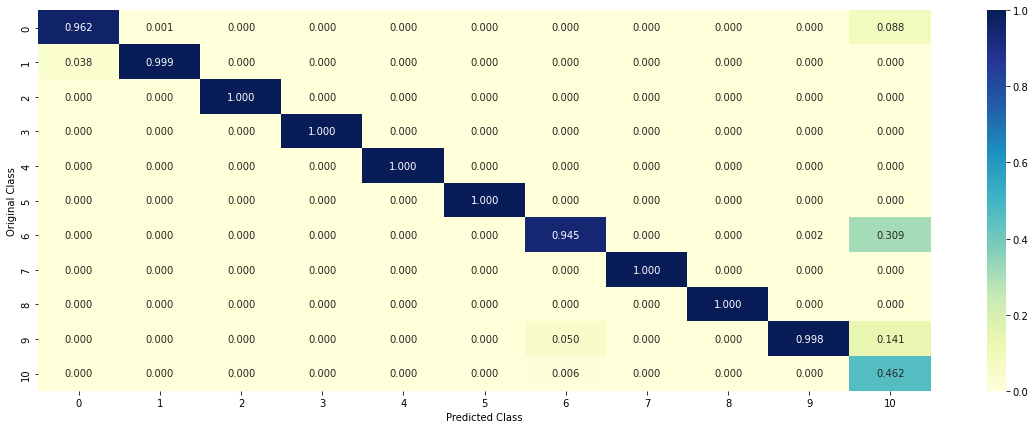

-------------------- Recall matrix (Row sum=1) --------------------


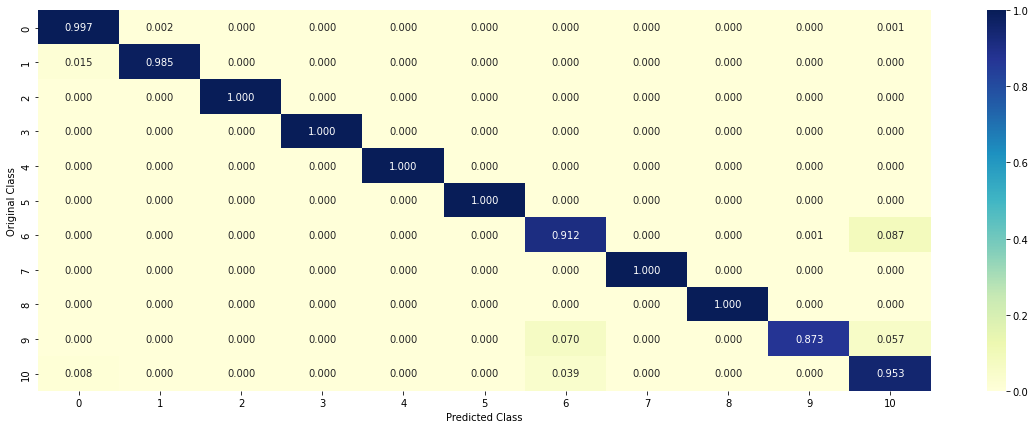

In [81]:
print('Below is how the product name and label relation as shown in the confusion, recall and precision matrix')

plot_confusion_matrix(trainy, train_data_pred_label)

-------------------- Confusion matrix --------------------


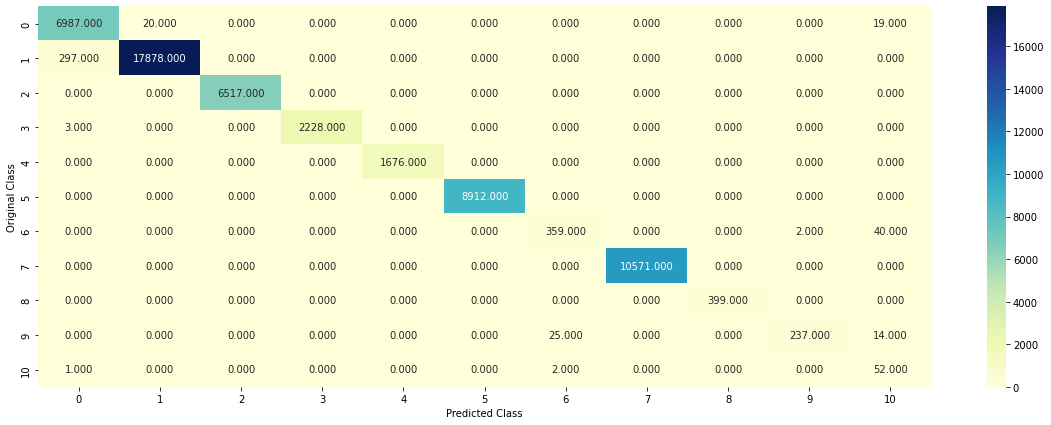

-------------------- Precision matrix (Columm Sum=1) --------------------


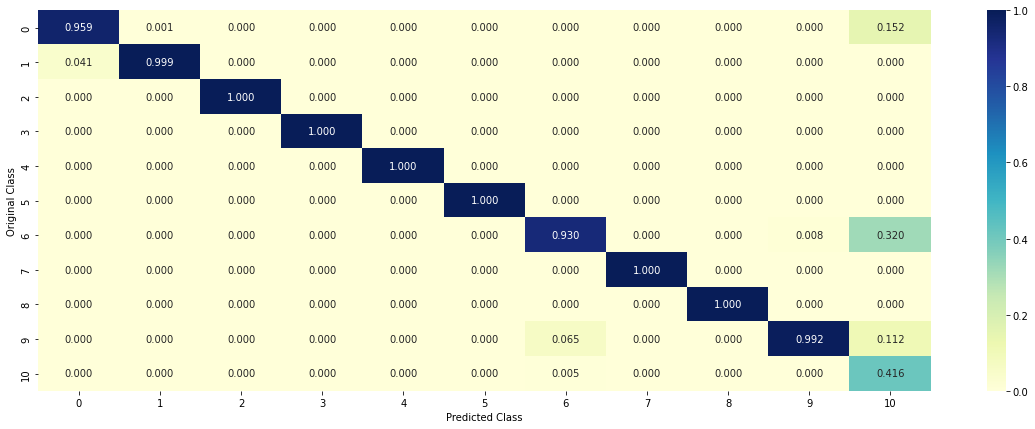

-------------------- Recall matrix (Row sum=1) --------------------


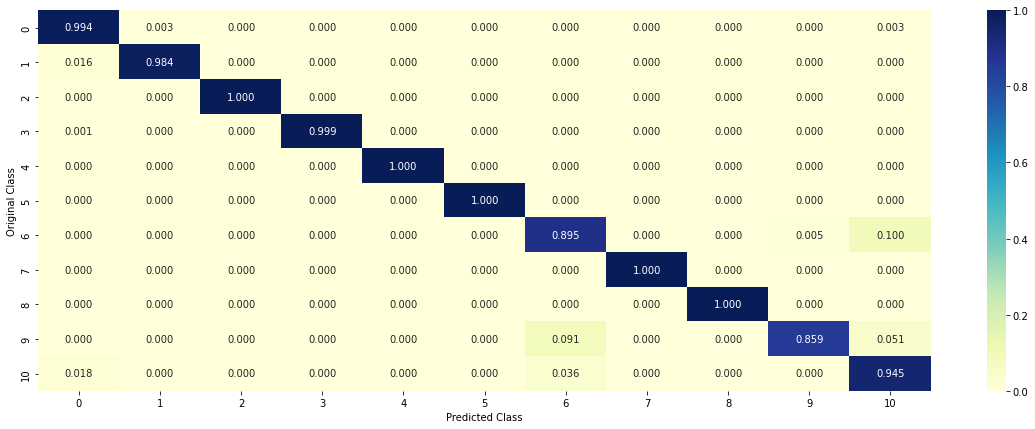

In [82]:
plot_confusion_matrix(testy, test_data_pred_label)

<h3> Feature importance of logistic regression model so far</h3>



In [84]:
from operator import itemgetter

top_indices = np.argsort(lr.coef_[0])[::-1][:20]
importances = sorted(lr.coef_[0])[::-1][:20]

pd.Series(itemgetter(*top_indices)(all_features))

0                             issue_Billing disputes
1        issue_Identity theft / Fraud / Embezzlement
2                                      si_LEFT_BLANK
3                         issue_APR or interest rate
4                   issue_Closing/Cancelling account
5                         issue_Credit determination
6                                     issue_Late fee
7                             issue_Credit reporting
8        issue_Customer service / Customer relations
9                            issue_Transaction issue
10                                   issue_Other fee
11                              issue_Payoff process
12               issue_Credit line increase/decrease
13                          issue_Delinquent account
14                                     issue_Rewards
15                           issue_Billing statement
16    issue_Credit card protection / Debt protection
17                        issue_Collection practices
18         issue_Unsolicited issuance of credi

In [ ]:
# We see that 

As we can see that the features are mostly from issue types which is logical since any consumer complaint can be categorized into different departments mostly by seeing the issue (or sub issue type). So our model is working fine. 

From the precision matrix and recall matrix, we can see that model is getting slightly confused between few classes as shown above.

#Error analysis

In [85]:
for i, j in zip(testx.loc[testy[testy==10].index, 'issue'], testx[test_data_pred_label==10]['issue']):
  if i!=j:
    print(i,'====>', j)
    print('\n')

Excessive fees ====> Fraud or scam


Customer service/Customer relations ====> Advertising and marketing


Customer service/Customer relations ====> Advertising and marketing


Excessive fees ====> Fraud or scam


Customer service/Customer relations ====> Excessive fees


Lost or stolen check ====> Fraud or scam


Fraud or scam ====> Customer service/Customer relations


Advertising and marketing ====> Fraud or scam


Customer service/Customer relations ====> Fraud or scam


Customer service/Customer relations ====> Advertising and marketing


Excessive fees ====> Fraud or scam


Customer service/Customer relations ====> Excessive fees


Customer service/Customer relations ====> Fraud or scam


Customer service/Customer relations ====> Fraud or scam


Lost or stolen check ====> Advertising and marketing


Customer service/Customer relations ====> Lost or stolen check


Customer service/Customer relations ====> Fraud or scam


Lost or stolen check ====> Fraud or scam


Unexpected/Other 

This is an example for class 10, (however the same concept can be used for other class miscalssifications as well). 

For class 10, wrong classfications we see that this model is getting confused among 

1. Customer service/Customer relations ====> Fraud or scam

2. Excessive fees ====> Customer service/Customer relation

3. Unexpected/Other fees ====> Fraud or scam


however they are minimal and not much.


#Random Forest

In [89]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(train_data, trainy)
rfc = CalibratedClassifierCV(rfc, cv='prefit')
rfc.fit(train_data, trainy)

test_data_pred=rfc.predict_proba(test_data) 
train_data_pred=rfc.predict_proba(train_data) 

train_data_pred_label=rfc.predict(train_data)
test_data_pred_label=rfc.predict(test_data) 

ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

# ohe=OneHotEncoder() 
trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))

print('train recall score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),3), 'test recall score', round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),3))
print('train precision score', round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),3), 'test precision score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),3))
print('train f1 score', round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),3), 'test f1 score', round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),3))



train recall score 0.998 test recall score 0.994
train precision score 0.994 test precision score 0.998
train f1 score 0.994 test f1 score 0.998


# hyper parameter tunning random forest

In [ ]:
param_grid={'n_estimators':[100, 200, 300, 400], 'min_samples_split': [2,4,6], 'min_samples_leaf':[2,4,6]}
rfc = RandomForestClassifier(class_weight='balanced') 
grid = GridSearchCV(rfc, param_grid, scoring='f1_micro')
grid.fit(train_data, trainy)
# print('grid_best_score', 'grid_best_param', grid.best_score_, grid.best_params_)

In [92]:
rfc = RandomForestClassifier(class_weight='balanced', min_samples_leaf= 2, min_samples_split= 6, n_estimators=200)
rfc.fit(train_data, trainy)
rfc = CalibratedClassifierCV(rfc, cv='prefit')
rfc.fit(train_data, trainy)

test_data_pred=rfc.predict_proba(test_data) 
train_data_pred=rfc.predict_proba(train_data) 

train_data_pred_label=rfc.predict(train_data)
test_data_pred_label=rfc.predict(test_data) 

ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

# ohe=OneHotEncoder() 
trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))


rf_train_recall = round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)
rf_test_recall = round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),8)

rf_train_precision = round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8) 
rf_test_precision = round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),8)

rf_train_f1_score = round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)
rf_test_f1_score = round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),8)                      


print('train recall score', rf_train_recall, 'test recall score', rf_test_recall)
print('train precision score', rf_train_precision , 'test precision score', rf_test_precision)
print('train f1 score', rf_train_f1_score, 'test f1 score', rf_test_f1_score)




train recall score 0.99349957 test recall score 0.99201622
train precision score 0.99349957 test precision score 0.99201622
train f1 score 0.99349957 test f1 score 0.99201622


**Confusion_Matrix**

Below is how the product name and label relation as shown in the confusion, recall and precision matrix
-------------------- Confusion matrix --------------------


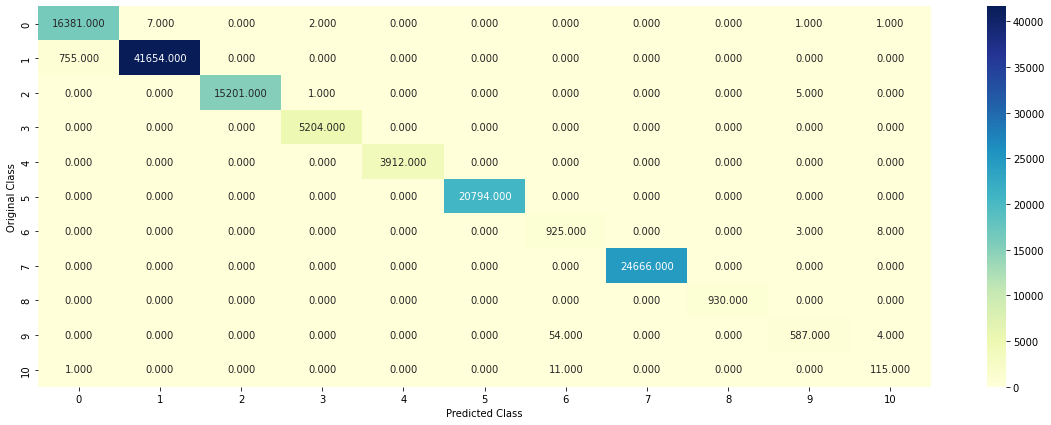

-------------------- Precision matrix (Columm Sum=1) --------------------


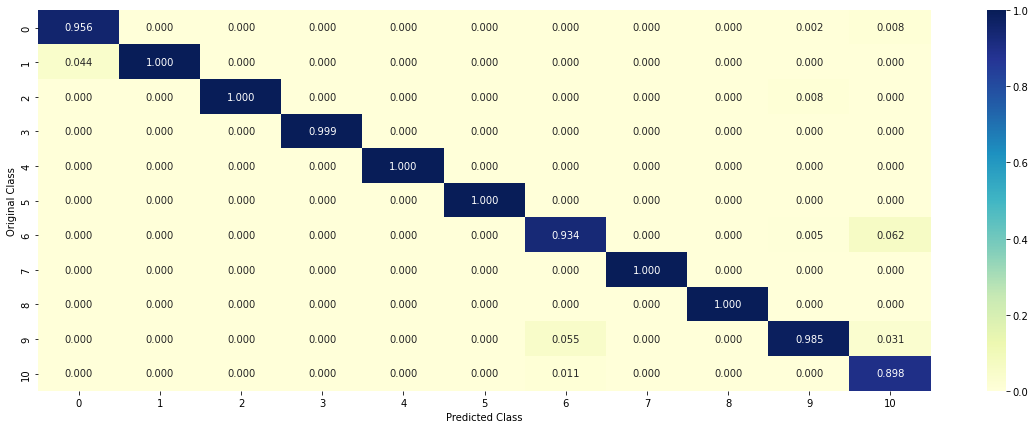

-------------------- Recall matrix (Row sum=1) --------------------


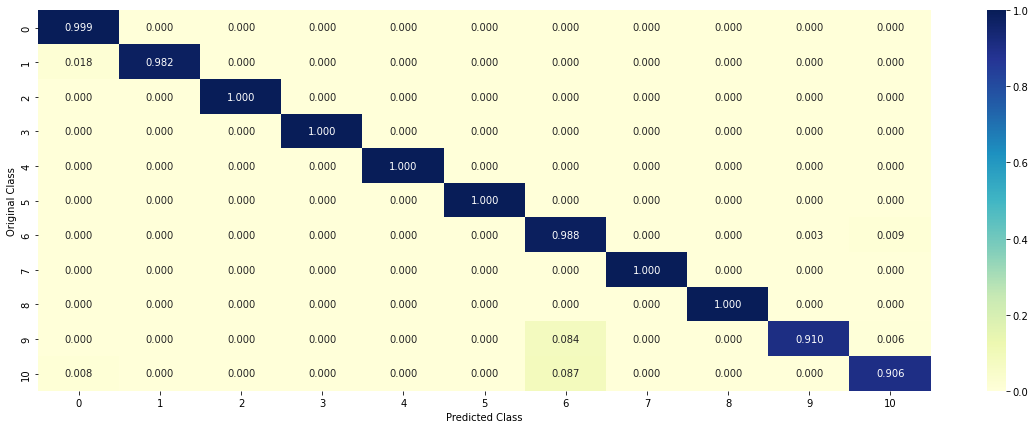

In [93]:

print('Below is how the product name and label relation as shown in the confusion, recall and precision matrix')

plot_confusion_matrix(trainy, train_data_pred_label)

-------------------- Confusion matrix --------------------


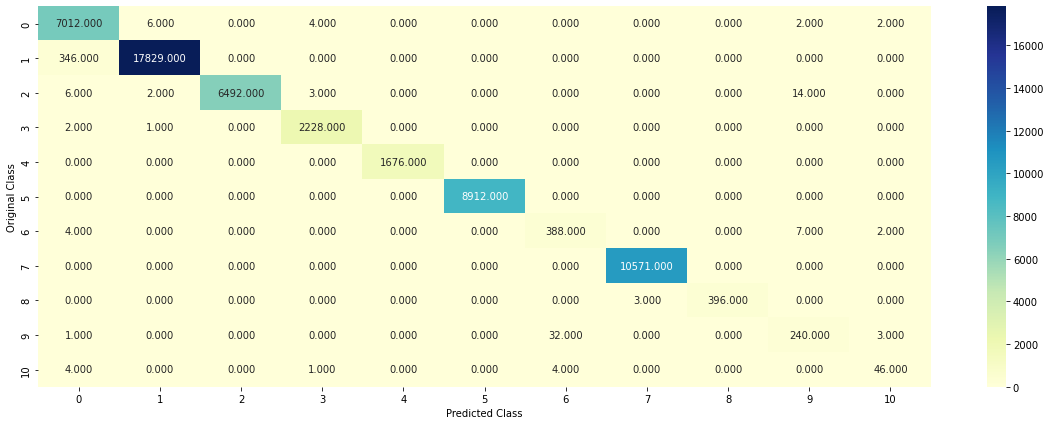

-------------------- Precision matrix (Columm Sum=1) --------------------


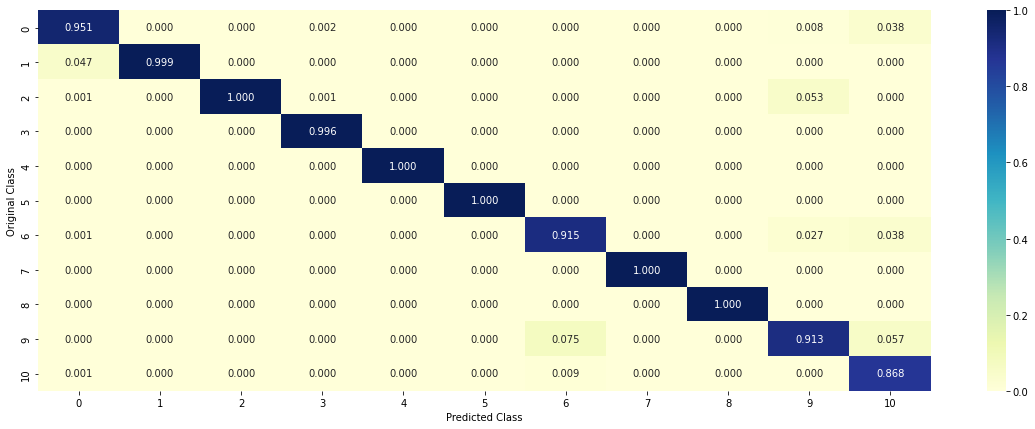

-------------------- Recall matrix (Row sum=1) --------------------


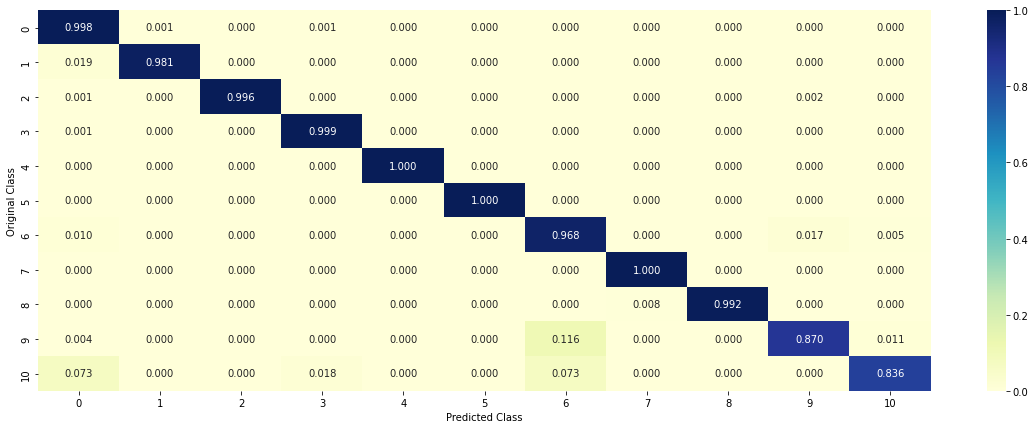

In [94]:
plot_confusion_matrix(testy, test_data_pred_label)

#Error analysis

In [95]:
for i, j in zip(testx.loc[testy[testy==10].index, 'issue'], testx[test_data_pred_label==10]['issue']):
  if i!=j:
    print(i,'====>', j)
    print('\n')

Excessive fees ====> Customer service/Customer relations


Customer service/Customer relations ====> Excessive fees


Excessive fees ====> Customer service/Customer relations


Customer service/Customer relations ====> Lost or stolen check


Lost or stolen check ====> Customer service/Customer relations


Fraud or scam ====> Advertising and marketing


Advertising and marketing ====> Customer service/Customer relations


Customer service/Customer relations ====> Excessive fees


Fraud or scam ====> Customer service/Customer relations


Excessive fees ====> Customer service/Customer relations


Customer service/Customer relations ====> Lost or stolen check


Customer service/Customer relations ====> Fraud or scam


Customer service/Customer relations ====> Fraud or scam


Lost or stolen check ====> Customer service/Customer relations


Customer service/Customer relations ====> Lost or stolen check


Lost or stolen check ====> Unexpected/Other fees


Unexpected/Other fees ====> Customer 

Above are the issues in which model is showing wrong answers but these are few.

#LGBMClassifier

In [96]:
lgb = LGBMClassifier(class_weight='balanced', objective='multiclass')
lgb.fit(train_data, trainy)
clb = CalibratedClassifierCV(lgb, cv='prefit')
clb.fit(train_data, trainy)


test_data_pred=lgb.predict_proba(test_data) 
train_data_pred=lgb.predict_proba(train_data) 

train_data_pred_label=lgb.predict(train_data)
test_data_pred_label=lgb.predict(test_data)


ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

# ohe=OneHotEncoder() 
trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))

print('train recall score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),3), 'test recall score', round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),3))
print('train precision score', round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),3), 'test precision score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),3))
print('train f1 score', round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),3), 'test f1 score', round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),3))



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


train recall score 0.997 test recall score 0.995
train precision score 0.995 test precision score 0.997
train f1 score 0.995 test f1 score 0.997


**Hyper paramater tunning**

In [ ]:
param_grid={'n_estimators':[100,200,300], 'learning_rate':[0.08, 0.1, 0.2], 'subsample':[0.8, 0.9, 1.0], 'colsample_bytree':[0.8, 0.9, 1.0]}
lgb = LGBMClassifier(class_weight='balanced', objective='multiclass') 
grid = GridSearchCV(lgb, param_grid, scoring='f1_micro')
grid.fit(train_data, trainy)

<h4>choosing the best hyper parameters</h4>

In [97]:
lgb = LGBMClassifier(class_weight='balanced', objective='multiclass', n_estimators=100, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8) 
lgb.fit(train_data, trainy)
clb = CalibratedClassifierCV(lgb, cv='prefit')
clb.fit(train_data, trainy)


test_data_pred=lgb.predict_proba(test_data) 
train_data_pred=lgb.predict_proba(train_data) 

train_data_pred_label=lgb.predict(train_data)
test_data_pred_label=lgb.predict(test_data)


ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

# ohe=OneHotEncoder() 
trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))

lgbm_train_recall = round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)
lgbm_test_recall = round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),8)

lgbm_train_precision = round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8) 
lgbm_test_precision = round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),8)

lgbm_train_f1_score = round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)
lgbm_test_f1_score = round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),8)                          


print('train recall score', lgbm_train_recall, 'test recall score', lgbm_test_recall)
print('train precision score', lgbm_train_precision , 'test precision score', lgbm_test_precision)
print('train f1 score', lgbm_train_f1_score, 'test f1 score', lgbm_test_f1_score) 


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


train recall score 0.99650211 test recall score 0.99482565
train precision score 0.99650211 test precision score 0.99482565
train f1 score 0.99650211 test f1 score 0.99482565


**Confusion Matrix**

Below is how the product name and label relation as shown in the confusion, recall and precision matrix
-------------------- Confusion matrix --------------------


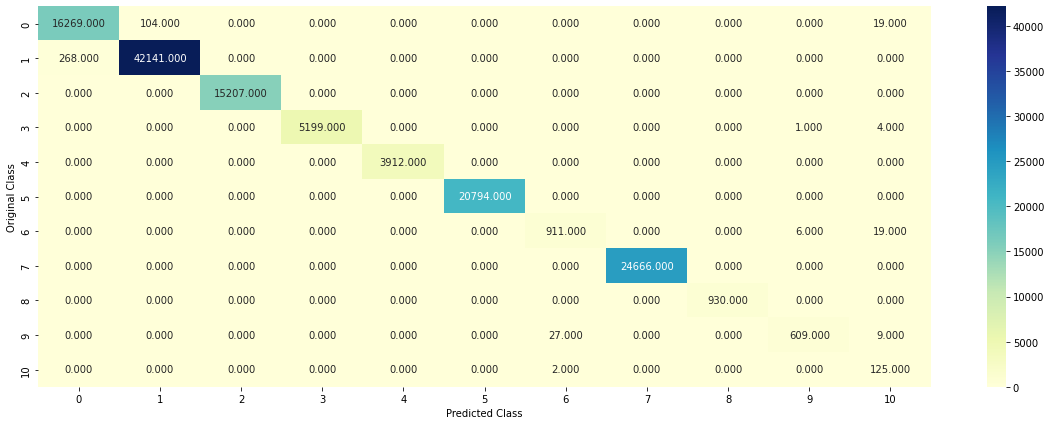

-------------------- Precision matrix (Columm Sum=1) --------------------


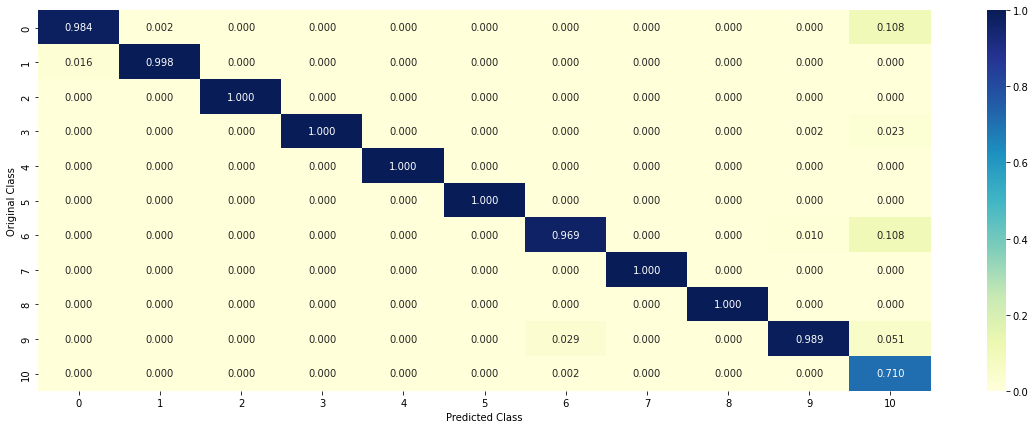

-------------------- Recall matrix (Row sum=1) --------------------


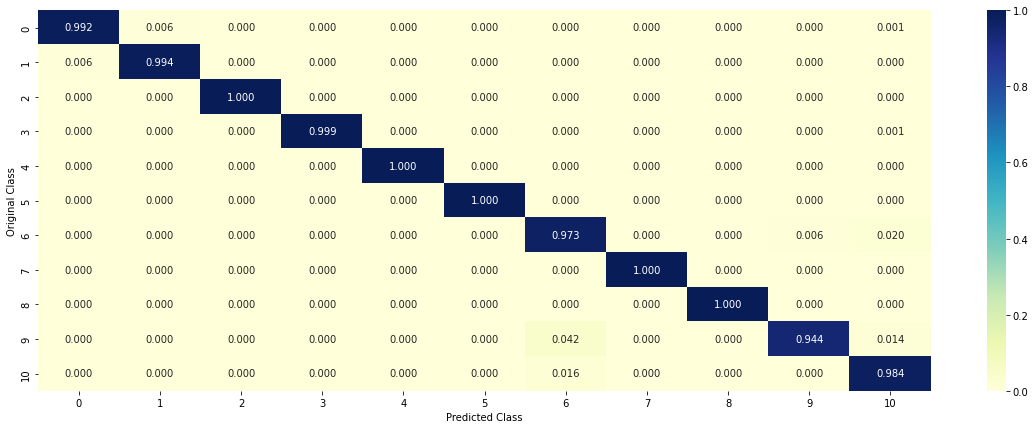

In [98]:

print('Below is how the product name and label relation as shown in the confusion, recall and precision matrix')


plot_confusion_matrix(trainy, train_data_pred_label)

Below is how the product name and label relation as shown in the confusion, recall and precision matrix
-------------------- Confusion matrix --------------------


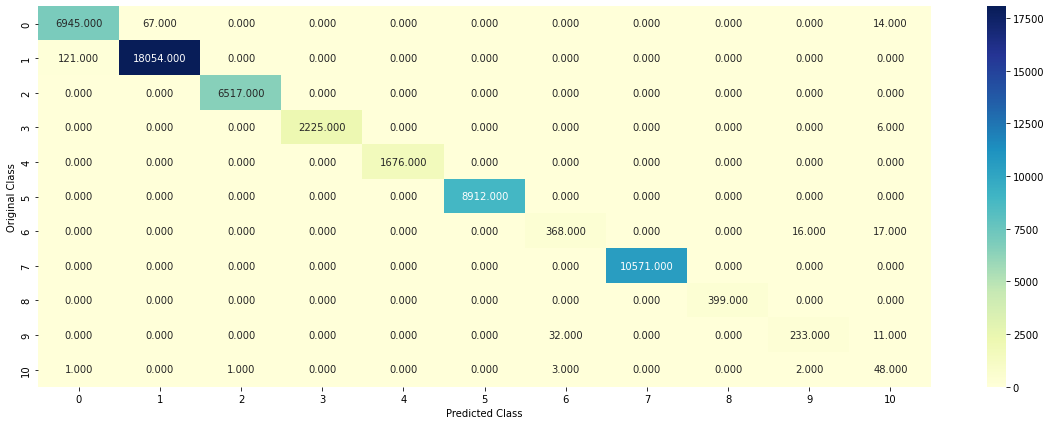

-------------------- Precision matrix (Columm Sum=1) --------------------


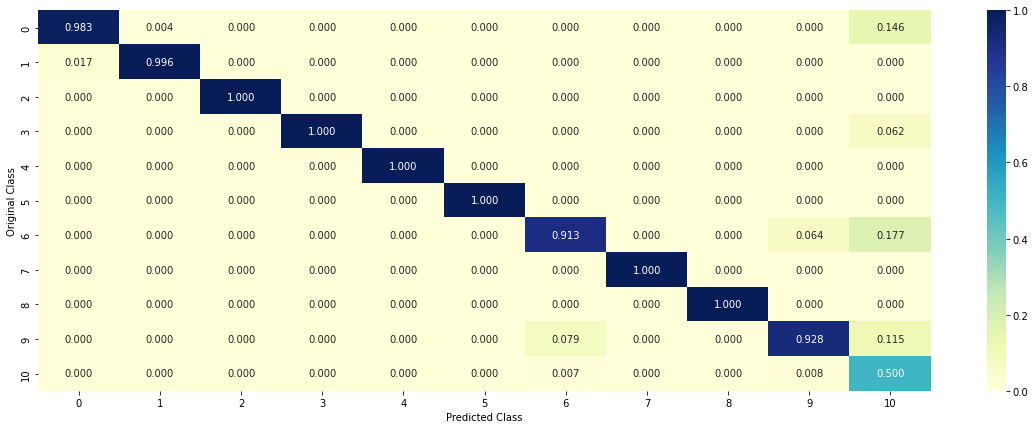

-------------------- Recall matrix (Row sum=1) --------------------


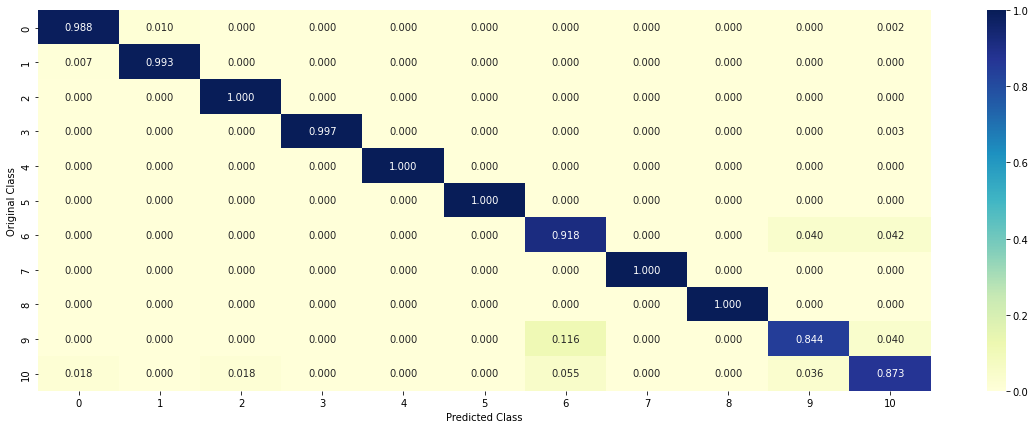

In [99]:

print('Below is how the product name and label relation as shown in the confusion, recall and precision matrix')


plot_confusion_matrix(testy, test_data_pred_label)

As we can see above that, class 8 was not predicted at all. Also from recall matrix class 10 was confused with class 6 and 3.

In [101]:
for i, j in zip(testx.loc[testy[testy==10].index, 'issue'], testx[test_data_pred_label==10]['issue']):
  if i!=j:
    print(i,'====>', j)
    print('\n')

Excessive fees ====> Fraud or scam


Customer service/Customer relations ====> Advertising and marketing


Customer service/Customer relations ====> Excessive fees


Excessive fees ====> Overdraft, savings or rewards features


Lost or stolen check ====> Customer service/Customer relations


Fraud or scam ====> Advertising, marketing or disclosures


Customer service/Customer relations ====> Excessive fees


Advertising and marketing ====> Fraud or scam


Customer service/Customer relations ====> Advertising and marketing


Fraud or scam ====> Advertising and marketing


Excessive fees ====> Lost or stolen check


Customer service/Customer relations ====> Fraud or scam


Customer service/Customer relations ====> Lender repossessed or sold the vehicle


Customer service/Customer relations ====> Overdraft, savings or rewards features


Lost or stolen check ====> Advertising and marketing


Lost or stolen check ====> Fraud or scam


Unexpected/Other fees ====> Excessive fees


Customer se

As shown above there are "issue" column result between which the model classes are getiing confused. 

#Conclusions so far:

1. Out of 5 models linear SVM woks best with 0.9963 f1 score.
2. There are some confusions between few classes that every model is showing specifically for "Prepaid card" product where the models are confusing between issues like "fraud, scam, unauthorised, Managing, opening, or closing account etc.

In [103]:
df = pd.DataFrame(columns = ['train_recall', 'train_precision', 'train_f1_score', 'test_recall', 'test_precision', 'test_f1_score' ], index = ['Naive Bayes','SVM', 'Logistic Regression', 'random_forest', 'LGBMClassifier'])


In [145]:
df['train_recall']=[mnb_train_recall, svm_train_recall, log_train_recall, rf_train_recall, lgbm_train_recall ]
df['train_precision']=[mnb_train_precision, svm_train_precision, log_train_precision, rf_train_precision, lgbm_train_precision ]
df['train_f1_score']=[mnb_train_f1_score, svm_train_f1_score, log_train_f1_score, rf_train_f1_score, lgbm_train_f1_score ]

df['test_recall']=[mnb_test_recall, svm_test_recall, log_test_recall, rf_test_recall, lgbm_test_recall ]
df['test_precision']=[mnb_test_precision, svm_test_precision, log_test_precision, rf_test_precision, lgbm_test_precision ]
df['test_f1_score']=[mnb_test_f1_score, svm_test_f1_score, log_test_f1_score, rf_test_f1_score, lgbm_test_f1_score ]

df


,train_recall,train_precision,train_f1_score,test_recall,test_precision,test_f1_score
Naive Bayes,0.994368,0.994368,0.994368,0.994310,0.994310,0.994310
SVM,0.996586,0.996586,0.996586,0.996337,0.996337,0.996337
Logistic Regression,0.996167,0.996167,0.996167,0.995768,0.995768,0.995768
random_forest,0.993500,0.993500,0.993500,0.992016,0.992016,0.992016
LGBMClassifier,0.996502,0.996502,0.996502,0.994826,0.994826,0.994826


<h3>CLearly SVM is the winner</h3>

<h2>Checking the robustness of the model by adding some noise to the test data.</h2>

In [113]:
train_data_csc = train_data.tocsc() 
test_data_csc = test_data.tocsc() 

noise = 0.001

n = test_data_csc.nonzero()

for row, col in zip(*n):
  test_data_csc[row, col]+=noise 
  

In [148]:
print(train_data.shape, test_data.shape, trainy.shape, testy.shape)

# lr = LogisticRegression(max_iter=500, class_weight='balanced', C=1000)
svm = SGDClassifier(loss='hinge', alpha=0.00001)
svm.fit(train_data, trainy)

svm = CalibratedClassifierCV(lgb, cv='prefit')
svm.fit(train_data, trainy)

test_data_pred=svm.predict_proba(test_data_csc) 

train_data_pred=svm.predict_proba(train_data) 

train_data_pred_label=svm.predict(train_data)
test_data_pred_label=svm.predict(test_data_csc) 

ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))

print('train recall score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8), 'test recall score', round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),8))
print('train precision score', round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),8), 'test precision score', round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8))
print('train f1 score', round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),8), 'test f1 score', round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)) 


(131222, 5255) (56239, 5255) (131222,) (56239,)


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


train recall score 0.99692125 test recall score 0.99507459
train precision score 0.99507459 test precision score 0.99692125
train f1 score 0.99507459 test f1 score 0.99692125


As shown above there are some the model performance remains similar to a certain extent after adding some noise to the existing data.

#IMPORTANT NOTE

Through forward feature engineering and feature importance we realized that issue and subissue were the most important features and other features did not add much value so we decided to drop them. 

In [162]:
trainx = hstack([trainx_issue, trainx_sub_issue])
testx = hstack([testx_issue, testx_sub_issue])
all_features = np.hstack([issue_features, si_features])

In [166]:
trainx.drop(['consumer_complaint_narrative', 'company', 'state', 'zipcode', 'tags', 'submitted_via', 'region_code'], axis=1, inplace=True)
testx.drop(['consumer_complaint_narrative', 'company', 'state', 'zipcode', 'tags', 'submitted_via', 'region_code'], axis=1, inplace=True)

In [167]:
ohe_issue = OneHotEncoder(handle_unknown='ignore')
trainx_issue = ohe_issue.fit_transform(trainx['issue'].values.reshape(-1,1))
testx_issue = ohe_issue.transform(testx['issue'].values.reshape(-1,1))
issue_features = ohe_issue.get_feature_names_out(['issue'])

ohe_sub_issue = OneHotEncoder(handle_unknown='ignore')
trainx_sub_issue = ohe_sub_issue.fit_transform(trainx['sub_issue'].values.reshape(-1,1))
testx_sub_issue = ohe_sub_issue.transform(testx['sub_issue'].values.reshape(-1,1))
si_features = ohe_sub_issue.get_feature_names_out(['si'])

train_data = hstack([trainx_issue, trainx_sub_issue])
test_data = hstack([testx_issue, testx_sub_issue])
all_features = np.hstack([issue_features, si_features])



In [168]:
svm = SGDClassifier(loss='hinge', alpha=0.00001)
svm.fit(train_data, trainy)
clb = CalibratedClassifierCV(svm, cv='prefit')
clb.fit(train_data, trainy)

test_data_pred=clb.predict_proba(test_data) 
train_data_pred=clb.predict_proba(train_data) 

train_data_pred_label=clb.predict(train_data)
test_data_pred_label=clb.predict(test_data)

ohe=OneHotEncoder()
trainy_ohe = ohe.fit_transform(np.asarray(trainy).reshape(-1,1))
testy_ohe = ohe.transform(np.asarray(testy).reshape(-1,1))

# ohe=OneHotEncoder() 
trainy_pred_ohe = ohe.transform(np.asarray(train_data_pred_label).reshape(-1,1))
testy_pred_ohe = ohe.transform(np.asarray(test_data_pred_label).reshape(-1,1))



svm_train_recall = round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)
svm_test_recall = round(recall_score(testy_ohe, testy_pred_ohe, average='micro'),8)

svm_train_precision = round(recall_score(trainy_ohe, trainy_pred_ohe, average='micro'),8) 
svm_test_precision = round(precision_score(testy_ohe, testy_pred_ohe, average='micro'),8)

svm_train_f1_score = round(f1_score(trainy_ohe, trainy_pred_ohe, average='micro'),8)
svm_test_f1_score = round(f1_score(testy_ohe, testy_pred_ohe, average='micro'),8)                          


print('train recall score', svm_train_recall, 'test recall score', svm_test_recall)
print('train precision score', svm_train_precision , 'test precision score', svm_test_precision)
print('train f1 score', svm_train_f1_score, 'test f1 score', svm_test_f1_score)


train recall score 0.99155629 test recall score 0.99224737
train precision score 0.99155629 test precision score 0.99224737
train f1 score 0.99155629 test f1 score 0.99224737


<h2> Please note that there was a dip of score 0.004 due to removal of features in making the model simpler, this was primarily done for the purpose of simplifying the webapp input taking process. While it may be appealing to consider those features at first however as compared to the scores .99 this is very minimal. Also it reduces the time complexity of training with so many features. Due to this, we decided to drop every other feature than issue and sub_issue, Since we tried this attempt to reduce the latency of our solution.  </h2>

# Storing the one hot ecnoded representations in dictionary and SVM model

In [169]:
import joblib

# =================================

issue_k = trainx['issue']
issue_v = ohe_issue.transform(np.array(issue_k).reshape(-1,1))  #.toarray()

issue_dict={}
for k,v in zip(issue_k, issue_v):
    issue_dict[k] = v

# =================================
sub_issue_k = trainx['sub_issue']
sub_issue_v = ohe_sub_issue.transform(np.array(sub_issue_k).reshape(-1,1))  #.toarray()

sub_issue_dict={}
for k,v in zip(sub_issue_k, sub_issue_v):
    sub_issue_dict[k] = v 


sub_issue_obj = joblib.dump(sub_issue_dict, 'sub_issue_vr.joblib')
issue_obj = joblib.dump(issue_dict, 'issue_vr.joblib')
svm_model_obj = joblib.dump(clb, 'svm_model.joblib') 


In [158]:
svm = CalibratedClassifierCV(svm, cv='prefit')
svm.fit(train_data, trainy)

svm_cal_model_obj = joblib.dump(svm, 'svm_cal_model.joblib') 
